In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
import re
# For visualization and future steps
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer  # Needed to enable the experimental feature
from sklearn.impute import IterativeImputer


In [2]:
import warnings
warnings.filterwarnings("ignore")  # optional

# Load baseline dataset
df = pd.read_csv("D:/Work/Insightrix/Unnamed Project/data_baseline.csv")

# Check basic structure
print("Shape of dataset:", df.shape)
print("\nSample columns:", df.columns.tolist()[:10])
print("\nMissing values:\n", df.isnull().sum().sort_values(ascending=False).head(10))


Shape of dataset: (6356, 222)

Sample columns: ['CIN5', 'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren', 'CAT_Benzodiazepine', 'CAT_Z.drugs', 'CAT_NSAIDs', 'CAT_ADHD', 'CAT_Antihypertensiva', 'CAT_Antihistaminica']

Missing values:
 Cernst_TK         6356
Ccriterium_TK     6356
responsBCDEFU6    6356
Bcriterium_IN     6356
Baantal_IN        6356
Bernst_IN         6356
Ccriterium_IN     6356
Caantal_IN        6356
Cernst_IN         6356
Dcriterium_IN     6356
dtype: int64


In [3]:
#!pip install pyreadstat


In [4]:
# Columns manually identified for removal (example set from the R script)
cols_to_drop = [
    'CIN5','StartDatum', 'STARTDATUM', 'DROPOUT_EARLYCOMPLETER', 'TOEST_WO',
    'depressie_IN', 'TERUGKOMER', 'VROEGK_ST',
    'depr_m_psychose_huid', 'depr_z_psychose_huid', 'depr_z_psychose_verl',
    'depr_m_psychose_verl', 'CAPS5score_followup', 'CAPS5_DAT_IN'
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
print("Remaining columns:", df.shape[1])


Remaining columns: 210


In [5]:
if 'BEH_DAGEN' in df.columns:
    df['BEH_DAGEN'] = df['BEH_DAGEN'].fillna(0)
    df.rename(columns={'BEH_DAGEN': 'treatment duration (days)'}, inplace=True)

In [6]:
# Clean and standardize column names
df.columns = (
    df.columns
    .str.replace(r"\.+", "_", regex=True)
    .str.replace(r"[^a-zA-Z0-9_]", "", regex=True)
    .str.replace(" ", "_")
    .str.strip()
)

In [7]:
# Preview key outcome variables
outcome_vars = ['CAPS5score_baseline', 'CAPS5Score_TK']
for col in outcome_vars:
    if col in df.columns:
        print(f"{col}: {df[col].isnull().sum()} missing")

# Calculate change score
if 'CAPS5score_baseline' in df.columns and 'CAPS5Score_TK' in df.columns:
    df['caps5_change_baseline'] = df['CAPS5Score_TK'] - df['CAPS5score_baseline']


CAPS5score_baseline: 0 missing
CAPS5Score_TK: 0 missing


In [8]:
# Define exceptions to keep
protected_cols = [
    "DIAGNOSIS_ANXIETY_OCD",
    "DIAGNOSIS_PSYCHOTIC",
    "DIAGNOSIS_EATING_DISORDER",
    "DIAGNOSIS_SUBSTANCE_DISORDER"
]

# ----------------------------------------
# 1. Drop columns with >95% missing values (except protected)
thresh_missing = int(0.95 * len(df))
missing_cols = [col for col in df.columns if df[col].isnull().sum() > (len(df) - thresh_missing)]
missing_cols_to_drop = [col for col in missing_cols if col not in protected_cols]
df = df.drop(columns=missing_cols_to_drop)

# ----------------------------------------
# 2. Drop near-zero variance columns (except protected)
low_variance_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1 and col not in protected_cols]
df = df.drop(columns=low_variance_cols)


In [9]:
df.to_csv("cleaned_data_baseline.csv", index=False)
print(" Step 1 Complete: Cleaned dataset saved.")

 Step 1 Complete: Cleaned dataset saved.


In [10]:
# Target variables:

In [11]:
#!pip install scikit-learn
# !pip install fancyimpute

In [12]:
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
# Load the cleaned dataset from Step 1
df = pd.read_csv("cleaned_data_baseline.csv")

# Quick check
print(df.shape)
print(df.dtypes.head(10))

(6356, 56)
CAT_Antipsychotica             int64
CAT_Antidepressiva             int64
CAT_Stemmingsstabilisatoren    int64
CAT_Benzodiazepine             int64
CAT_Z_drugs                    int64
CAT_NSAIDs                     int64
CAT_ADHD                       int64
CAT_Antihypertensiva           int64
CAT_Antihistaminica            int64
CAT_Anti_epileptica            int64
dtype: object


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6356 entries, 0 to 6355
Data columns (total 56 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   CAT_Antipsychotica                              6356 non-null   int64  
 1   CAT_Antidepressiva                              6356 non-null   int64  
 2   CAT_Stemmingsstabilisatoren                     6356 non-null   int64  
 3   CAT_Benzodiazepine                              6356 non-null   int64  
 4   CAT_Z_drugs                                     6356 non-null   int64  
 5   CAT_NSAIDs                                      6356 non-null   int64  
 6   CAT_ADHD                                        6356 non-null   int64  
 7   CAT_Antihypertensiva                            6356 non-null   int64  
 8   CAT_Antihistaminica                             6356 non-null   int64  
 9   CAT_Anti_epileptica                      

In [15]:
# Separate Numerical and Categorical Variables

In [16]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical Columns: {len(numerical_cols)}")
print(f"Categorical Columns: {len(categorical_cols)}")

Numerical Columns: 56
Categorical Columns: 0


In [17]:
# Step 2: Create CAT_ALL
# CAT_ALL: Any column that starts with 'CAT_', but NOT 'SUBCAT_' or 'SUBSUBCAT_'
cat_cols = [col for col in df.columns if col.startswith('CAT_') and not col.startswith(('SUBCAT_', 'SUBSUBCAT_'))]
df['CAT_ALL'] = (df[cat_cols].fillna(0).sum(axis=1) >= 1).astype(int)
# Step 3: Create CAT_ALL_PSYCHOTROPICS
# Specific psychotropic categories
psychotropic_cat_cols = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Benzodiazepine',
    'CAT_Z.drugs', 'CAT_ADHD', 'CAT_Anti.epileptica', 'CAT_Opioiden'
]
# Keep only the columns that exist in the data (in case some are missing)
psychotropic_cat_cols = [col for col in psychotropic_cat_cols if col in df.columns]
df['CAT_ALL_PSYCHOTROPICS'] = (df[psychotropic_cat_cols].fillna(0).sum(axis=1) >= 1).astype(int)
# Step 4: Create CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS
# Exclude benzodiazepines and z-drugs
nonsedative_psychotropic_cols = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_ADHD',
    'CAT_Anti.epileptica', 'CAT_Opioiden'
]
# Keep only existing ones
nonsedative_psychotropic_cols = [col for col in nonsedative_psychotropic_cols if col in df.columns]
df['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = (df[nonsedative_psychotropic_cols].fillna(0).sum(axis=1) >= 1).astype(int)
# Step 5: Confirm
print(df[['CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS']].head())

   CAT_ALL  CAT_ALL_PSYCHOTROPICS  CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS
0        0                      0                                           0
1        1                      1                                           1
2        0                      0                                           0
3        1                      1                                           0
4        0                      0                                           0


In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. Ensure numerical_cols contains only numeric columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 2. Create and apply the imputer
num_imputer = IterativeImputer(max_iter=10, random_state=42)

# 3. Fit and transform safely
imputed_array = num_imputer.fit_transform(df[numerical_cols])  # shape: (n_rows, n_numerical_cols)

# 4. Convert to DataFrame and assign back with matching column names
df[numerical_cols] = pd.DataFrame(imputed_array, columns=numerical_cols, index=df.index)


In [19]:
def round_all_numeric_columns(df, decimals=0, verbose=True):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].round(decimals)

    if verbose:
        print(f"✅ Rounded {len(numeric_cols)} numeric columns to {decimals} decimal place(s).")

    return df

df = round_all_numeric_columns(df)


✅ Rounded 59 numeric columns to 0 decimal place(s).


In [20]:
# Save the fully prepared data
df.to_csv("final_prepared_data.csv", index=False)
print(" Step 2 Complete: Final prepared dataset saved as 'final_prepared_data.csv'.")

 Step 2 Complete: Final prepared dataset saved as 'final_prepared_data.csv'.


In [21]:
# Load the fully processed data
df = pd.read_csv("final_prepared_data.csv")

# Quick look
print(df.shape)
df.head()

(6356, 59)


,CAT_Antipsychotica,CAT_Antidepressiva,CAT_Stemmingsstabilisatoren,CAT_Benzodiazepine,CAT_Z_drugs,CAT_NSAIDs,CAT_ADHD,CAT_Antihypertensiva,CAT_Antihistaminica,CAT_Anti_epileptica,...,treatmentdurationdays,age,gender,CAPS5score_baseline,CAPS5Score_TK,ethnicity,caps5_change_baseline,CAT_ALL,CAT_ALL_PSYCHOTROPICS,CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30.0,2.0,45.0,4.0,1.0,-41.0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,67.0,2.0,37.0,22.0,1.0,-15.0,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,69.0,1.0,39.0,5.0,1.0,-34.0,0,0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.0,2.0,41.0,28.0,1.0,-13.0,1,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,43.0,1.0,28.0,11.0,1.0,-17.0,0,0,0


In [22]:
# Define the target outcome
Y = df['caps5_change_baseline']

print("Y defined successfully. Sample values:")
print(Y.head())

Y defined successfully. Sample values:
0   -41.0
1   -15.0
2   -34.0
3   -13.0
4   -17.0
Name: caps5_change_baseline, dtype: float64


In [23]:
# for all med groups

In [24]:
# See all CAT_* variables in the final data
cat_columns = [col for col in df.columns if col.startswith('CAT_')]
print("Medication Groups:")
print(cat_columns)
print("\nTotal Medication Groups Found:", len(cat_columns))

Medication Groups:
['CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren', 'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD', 'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica', 'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia', 'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS']

Total Medication Groups Found: 18


In [25]:
covariates_cat_adhd = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica', 'CAT_Antidepressiva',
    'CAT_Antihistaminica', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia', 'CAT_Stemmingsstabilisatoren',
    'CAT_Z_drugs', 'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD',
    'DIAGNOSIS_SEXUAL_TRAUMA', 'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY',
    'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren', 'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI', 'SUBCAT_Systemische_antihistaminica',
    'SUBCAT_Systemische_betablokkers', 'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_Z_drugs', 'SUBCAT_anxiolytica_Benzodiazepine',
    'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_stemm_Lithiumzouten', 'SUBCAT_stemm_benzamide', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_acet = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Anti_epileptica', 'CAT_Antidepressiva',
    'CAT_Antihistaminica', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers', 'SUBCAT_Z_drugs',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_stemm_Lithiumzouten',
    'SUBCAT_stemm_benzamide', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_zdrugs = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Anti_epileptica', 'CAT_Antidepressiva',
    'CAT_Antihistaminica', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_Anti_epileptica_GABA_analogon', 'SUBCAT_Anti_epileptica_overig',
    'SUBCAT_Anti_epileptica_stemmingsstabilisatoren', 'SUBCAT_Antidepressiva_overige',
    'SUBCAT_Antipsychotica_Klassiek', 'SUBCAT_Antipsychotica_atypisch',
    'SUBCAT_NSAIDs', 'SUBCAT_Opioden', 'SUBCAT_Systemische_antihistaminica',
    'SUBCAT_Tetracyclische_antidepressiva', 'SUBCAT_anxiolytica_Benzodiazepine',
    'SUBCAT_hypnotica_Benzodiazepine', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_stemmingsstabilisatoren = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_NSAIDs', 'CAT_Opioden',
    'CAT_Spierrelaxantia', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
    
]



covariates_cat_spierrelaxantia = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_NSAIDs', 'CAT_Opioden',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_opioden = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_NSAIDs', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_nsaids = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]




covariates_cat_migrainemiddelen = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_immunomodulerende_middelen = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Benzodiazepine', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_benzodiazepine = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Antipsychotica', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_antihypertensiva = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_antihistaminica = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_betablokkers', 'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_anti_epileptica = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Antidepressiva',
    'CAT_Antihistaminica', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch',
    'SUBCAT_Clonidine',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]




covariates_cat_antidepressiva = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antihistaminica', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antipsychotica_Klassiek', 'SUBCAT_Antipsychotica_atypisch',
    'SUBCAT_Anti_epileptica_GABA_analogon', 'SUBCAT_Anti_epileptica_overig',
    'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs', 'SUBCAT_Paracetamol_mono',
    'SUBCAT_SNRI', 'SUBCAT_SSRI', 'SUBCAT_Systemische_antihistaminica',
    'SUBCAT_Systemische_betablokkers', 'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_antipsychotica = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia',
    'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige',
    'SUBCAT_Anti_epileptica_GABA_analogon', 'SUBCAT_Anti_epileptica_overig',
    'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs', 'SUBCAT_Paracetamol_mono',
    'SUBCAT_SNRI', 'SUBCAT_SSRI', 'SUBCAT_Systemische_antihistaminica',
    'SUBCAT_Systemische_betablokkers', 'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_psychotropics_excl_sedatives_hypnotics = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen', 'CAT_NSAIDs',
    'CAT_Opioden', 'CAT_Spierrelaxantia', 'CAT_Stemmingsstabilisatoren',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen',
    'SUBCAT_Antidepressiva_overige', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
     'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_all_psychotropics = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_Aceetanilidederivaten', 'CAT_Antihistaminica',
    'CAT_Antihypertensiva', 'CAT_Immunomodulerende_middelen',
    'CAT_NSAIDs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs',
    'SUBCAT_Paracetamol_mono',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_all = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'DIAGNOSIS_CHILDHOOD_TRAUMA',
    'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY',
    'age', 'ethnicity', 'gender', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


In [26]:
import os

# 1. Define correct medication groups (all 18)
medication_groups = [
    'CAT_Antipsychotica',
    'CAT_Antidepressiva',
    'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine',
    'CAT_Z_drugs',
    'CAT_NSAIDs',
    'CAT_ADHD',
    'CAT_Antihypertensiva',
    'CAT_Antihistaminica',
    'CAT_Anti_epileptica',
    'CAT_Opioden',
    'CAT_Aceetanilidederivaten',
    'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen',
    'CAT_Spierrelaxantia',
    'CAT_ALL',
    'CAT_ALL_PSYCHOTROPICS',
    'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# 2. Define hardcoded covariates for each treatment group
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# 3. Loop through each medication group
for treatment_var in medication_groups:
    print(f"\n========== Processing {treatment_var} ==========")

    # 4. Check if treatment variable exists in dataset
    if treatment_var not in df.columns:
        print(f"Treatment variable {treatment_var} not found in dataset! Skipping...")
        continue

    # 5. Define T
    T = df[treatment_var]
    print(f" T defined successfully for {treatment_var}. Value counts:")
    print(T.value_counts())

    # ✅ Use correct covariate list from hardcoded map
    covariates = final_covariates_map[treatment_var]

    # 6. Create output folder
    output_folder = os.path.join('outputs', treatment_var)
    os.makedirs(output_folder, exist_ok=True)
    print(f" Output folder created at {output_folder}")



========== Processing CAT_Antipsychotica ==========
 T defined successfully for CAT_Antipsychotica. Value counts:
CAT_Antipsychotica
0.0    5976
1.0     380
Name: count, dtype: int64
 Output folder created at outputs\CAT_Antipsychotica

========== Processing CAT_Antidepressiva ==========
 T defined successfully for CAT_Antidepressiva. Value counts:
CAT_Antidepressiva
0.0    5449
1.0     907
Name: count, dtype: int64
 Output folder created at outputs\CAT_Antidepressiva

========== Processing CAT_Stemmingsstabilisatoren ==========
 T defined successfully for CAT_Stemmingsstabilisatoren. Value counts:
CAT_Stemmingsstabilisatoren
0.0    6342
1.0      14
Name: count, dtype: int64
 Output folder created at outputs\CAT_Stemmingsstabilisatoren

========== Processing CAT_Benzodiazepine ==========
 T defined successfully for CAT_Benzodiazepine. Value counts:
CAT_Benzodiazepine
0.0    5773
1.0     583
Name: count, dtype: int64
 Output folder created at outputs\CAT_Benzodiazepine

========== Proc

In [27]:
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 🚨 Ensure 'df' is defined before running this block

medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# ✅ Use hardcoded covariates
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

for treatment_var in medication_groups:
    print(f"\n🔍 Processing {treatment_var}...")

    try:
        df_temp = df.copy()

        # ✅ Step 1: Use hardcoded covariates directly
        final_covariates = final_covariates_map[treatment_var]
        X = df_temp[final_covariates].copy()
        num_cols = X.select_dtypes(include=['int64', 'float64']).columns

        output_folder = os.path.join("outputs", treatment_var)
        os.makedirs(output_folder, exist_ok=True)

        for imp_num in range(1, 6):
            print(f"🔁 Imputation {imp_num}")
            X_imp = X.copy()
            imputer = IterativeImputer(max_iter=10, random_state=42 + imp_num)
            X_imp[num_cols] = imputer.fit_transform(X_imp[num_cols])
            X_imp.to_csv(os.path.join(output_folder, f'X_matrix_imputed_{treatment_var}_imp{imp_num}.csv'), index=False)

            if imp_num == 1:
                X_vif = sm.add_constant(X_imp)
                vif_data = pd.DataFrame()
                vif_data["Feature"] = X_vif.columns
                vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
                vif_data.to_excel(os.path.join(output_folder, f"vif_{treatment_var}.xlsx"), index=False)

        pd.DataFrame(final_covariates, columns=["Final Covariates"]).to_excel(
            os.path.join(output_folder, f"final_covariates_{treatment_var}.xlsx"), index=False
        )

        print(f"✅ Done: {treatment_var}")

    except Exception as e:
        print(f"❌ Error in {treatment_var}: {e}")



🔍 Processing CAT_Antipsychotica...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_Antipsychotica

🔍 Processing CAT_Antidepressiva...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_Antidepressiva

🔍 Processing CAT_Stemmingsstabilisatoren...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_Stemmingsstabilisatoren

🔍 Processing CAT_Benzodiazepine...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_Benzodiazepine

🔍 Processing CAT_Z_drugs...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_Z_drugs

🔍 Processing CAT_NSAIDs...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_NSAIDs

🔍 Processing CAT_ADHD...
🔁 Imputation 1
🔁 Imputation 2
🔁 Imputation 3
🔁 Imputation 4
🔁 Imputation 5
✅ Done: CAT_ADHD

🔍 Processing CAT_Antihypertensiva...
🔁 Imputation 1
🔁 Imputation 

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# ----------------------------------------
# Define medication groups (18 total)
# ----------------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# ✅ Hardcoded covariate lists
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# ----------------------------------------
# Loop over each treatment group
# ----------------------------------------
for treatment_var in medication_groups:
    print(f"\n🔄 Processing: {treatment_var}")
    output_folder = os.path.join("outputs", treatment_var)

    if not os.path.exists(output_folder):
        print(f"⚠️ Folder missing: {output_folder}. Skipping...")
        continue

    ps_list = []
    auc_list = []

    try:
        for imp_num in range(1, 6):
            X_path = os.path.join(output_folder, f"X_matrix_imputed_{treatment_var}_imp{imp_num}.csv")
            if not os.path.exists(X_path):
                print(f"❌ Missing file: {X_path}")
                continue

            X = pd.read_csv(X_path)
            T = df[treatment_var].copy()

            # ✅ Use only hardcoded covariates
            final_covariates = final_covariates_map[treatment_var]
            X = X[final_covariates]

            # Align indices
            X = X.loc[T.index]

            # Train-test split
            X_train, X_test, T_train, T_test = train_test_split(
                X, T, test_size=0.3, stratify=T, random_state=42
            )

            model = XGBClassifier(
                n_estimators=300,
                max_depth=5,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42 + imp_num
            )

            model.fit(X_train, T_train)
            ps_pred = model.predict_proba(X)[:, 1]
            ps_list.append(ps_pred)

            test_probs = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(T_test, test_probs)
            auc_list.append(auc)
            print(f"📊 AUC for {treatment_var} (Imp {imp_num}): {auc:.4f}")

            fpr, tpr, _ = roc_curve(T_test, test_probs)
            plt.figure()
            plt.plot(fpr, tpr, label=f"Imp {imp_num} AUC={auc:.3f}")
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
            plt.title(f"ROC Curve - {treatment_var} (Imp {imp_num})")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f"roc_curve_{treatment_var}_imp{imp_num}.png"))
            plt.close()

        if ps_list:
            ps_composite = np.mean(ps_list, axis=0)

            df_ps = pd.DataFrame({
                f"ps_{treatment_var}_imp{i+1}": ps_list[i] for i in range(len(ps_list))
            })
            df_ps[f"ps_{treatment_var}_composite"] = ps_composite

            df_ps.to_excel(os.path.join(output_folder, f"propensity_scores_{treatment_var}_composite.xlsx"), index=False)

            auc_df = pd.DataFrame({
                "Imputation": [f"Imp{i+1}" for i in range(len(auc_list))],
                "AUC": auc_list
            })
            auc_df.loc[len(auc_df)] = ["Mean AUC", np.mean(auc_list)]
            auc_df.to_excel(os.path.join(output_folder, f"auc_summary_{treatment_var}.xlsx"), index=False)

            print(f"✅ Saved composite scores and AUC summary for {treatment_var}")

        else:
            print(f"⚠️ No valid imputations found for {treatment_var}")

    except Exception as e:
        print(f"❌ Error in {treatment_var}: {e}")



🔄 Processing: CAT_Antipsychotica
📊 AUC for CAT_Antipsychotica (Imp 1): 0.8052
📊 AUC for CAT_Antipsychotica (Imp 2): 0.8105
📊 AUC for CAT_Antipsychotica (Imp 3): 0.8099
📊 AUC for CAT_Antipsychotica (Imp 4): 0.8137
📊 AUC for CAT_Antipsychotica (Imp 5): 0.8013
✅ Saved composite scores and AUC summary for CAT_Antipsychotica

🔄 Processing: CAT_Antidepressiva
📊 AUC for CAT_Antidepressiva (Imp 1): 0.9911
📊 AUC for CAT_Antidepressiva (Imp 2): 0.9902
📊 AUC for CAT_Antidepressiva (Imp 3): 0.9917
📊 AUC for CAT_Antidepressiva (Imp 4): 0.9906
📊 AUC for CAT_Antidepressiva (Imp 5): 0.9899
✅ Saved composite scores and AUC summary for CAT_Antidepressiva

🔄 Processing: CAT_Stemmingsstabilisatoren
📊 AUC for CAT_Stemmingsstabilisatoren (Imp 1): 0.8731
📊 AUC for CAT_Stemmingsstabilisatoren (Imp 2): 0.8820
📊 AUC for CAT_Stemmingsstabilisatoren (Imp 3): 0.8643
📊 AUC for CAT_Stemmingsstabilisatoren (Imp 4): 0.8882
📊 AUC for CAT_Stemmingsstabilisatoren (Imp 5): 0.8865
✅ Saved composite scores and AUC summary 

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# --------------------------------
# Medication Groups (18 total)
# --------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# ✅ Hardcoded covariate lists
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# --------------------------------------
# Feature Importance over Multiple Imputations
# --------------------------------------
for treatment_var in medication_groups:
    print(f"\n========== Averaged Feature Importance for {treatment_var} ==========")

    try:
        output_folder = os.path.join("outputs", treatment_var)
        importances_list = []
        feature_names = None

        for imp_num in range(1, 6):
            imp_path = os.path.join(output_folder, f"X_matrix_imputed_{treatment_var}_imp{imp_num}.csv")
            if not os.path.exists(imp_path):
                print(f"❌ Missing imputed file: {imp_path}")
                continue

            X_all = pd.read_csv(imp_path)
            if treatment_var not in df.columns:
                print(f"❌ Treatment column missing in df: {treatment_var}")
                continue
            T = df[treatment_var]

            # ✅ Use only hardcoded covariates
            selected_columns = final_covariates_map[treatment_var]
            X = X_all[selected_columns]
            X = X.select_dtypes(include='number')
            X.index = T.index

            model = XGBClassifier(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42 + imp_num
            )
            model.fit(X, T)
            importances_list.append(model.feature_importances_)
            feature_names = X.columns

        if not importances_list:
            print(f"⚠️ No imputations available for {treatment_var}. Skipping...")
            continue

        # Average and std deviation of feature importances
        importances_array = np.array(importances_list)
        avg_importance = np.mean(importances_array, axis=0)
        std_importance = np.std(importances_array, axis=0)

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Avg_Importance': avg_importance,
            'Std_Importance': std_importance
        })
        feature_importance_df = feature_importance_df.sort_values(by='Avg_Importance', ascending=False)
        top_features_df = feature_importance_df.head(30)

        # Save to Excel
        excel_path = os.path.join(output_folder, f'xgboost_avg_feature_importance_{treatment_var}.xlsx')
        top_features_df.to_excel(excel_path, index=False)

        # Plot top 25 features
        top_plot = top_features_df.head(25)
        plt.figure(figsize=(10, 8))
        plt.barh(top_plot['Feature'], top_plot['Avg_Importance'], xerr=top_plot['Std_Importance'], color='skyblue')
        plt.gca().invert_yaxis()
        plt.xlabel('Average Importance')
        plt.title(f'Avg Feature Importance with Std Dev: {treatment_var}')
        plt.tight_layout()

        plot_path = os.path.join(output_folder, f'xgboost_avg_feature_importance_plot_{treatment_var}.png')
        plt.savefig(plot_path, dpi=300)
        plt.close()

        print(f"✅ Saved averaged importance and plot for {treatment_var}")

    except Exception as e:
        print(f"❌ Error processing {treatment_var}: {e}")



========== Averaged Feature Importance for CAT_Antipsychotica ==========
✅ Saved averaged importance and plot for CAT_Antipsychotica

========== Averaged Feature Importance for CAT_Antidepressiva ==========
✅ Saved averaged importance and plot for CAT_Antidepressiva

========== Averaged Feature Importance for CAT_Stemmingsstabilisatoren ==========
✅ Saved averaged importance and plot for CAT_Stemmingsstabilisatoren

========== Averaged Feature Importance for CAT_Benzodiazepine ==========
✅ Saved averaged importance and plot for CAT_Benzodiazepine

========== Averaged Feature Importance for CAT_Z_drugs ==========
✅ Saved averaged importance and plot for CAT_Z_drugs

========== Averaged Feature Importance for CAT_NSAIDs ==========
✅ Saved averaged importance and plot for CAT_NSAIDs

========== Averaged Feature Importance for CAT_ADHD ==========
✅ Saved averaged importance and plot for CAT_ADHD

========== Averaged Feature Importance for CAT_Antihypertensiva ==========
✅ Saved averaged i

In [30]:
import os
import pandas as pd
import numpy as np

# --------------------------------
# Define medication groups (18)
# --------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# ✅ Hardcoded covariate lists
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# --------------------------------
# Rubin's Rule Function
# --------------------------------
def rubins_rule(values):
    m = len(values)
    q_bar = np.mean(values, axis=0)
    u_bar = np.mean(np.var(values, axis=0, ddof=1))
    b_m = np.var(np.mean(values, axis=1), ddof=1)
    total_var = u_bar + (1 + 1/m) * b_m
    total_se = np.sqrt(total_var)
    return q_bar, total_se

# --------------------------------
# Main Loop
# --------------------------------
for treatment_var in medication_groups:
    print(f"\n========== Rubin IPTW for {treatment_var} ==========")

    try:
        T = df[treatment_var].values
        p_treated = np.mean(T)
        output_folder = os.path.join('outputs', treatment_var)

        ps_path = os.path.join(output_folder, f'propensity_scores_{treatment_var}_composite.xlsx')
        if not os.path.exists(ps_path):
            print(f"❌ Missing: {ps_path}")
            continue

        ps_df = pd.read_excel(ps_path)

        imp_cols = [col for col in ps_df.columns if col.startswith(f'ps_{treatment_var}_imp')]
        if len(imp_cols) < 5:
            print(f"⚠️ Found only {len(imp_cols)} imputations. Expecting 5.")
            continue

        # ✅ Use hardcoded covariate list
        covariates = final_covariates_map[treatment_var]
        # (Optional) If needed later: X = df[covariates]

        # Compute IPTW weights for each imputation
        iptw_list = []
        iptw_df = pd.DataFrame({treatment_var: T})

        for i, col in enumerate(imp_cols, start=1):
            ps = ps_df[col].values
            iptw = T * (p_treated / ps) + (1 - T) * ((1 - p_treated) / (1 - ps))
            iptw_clipped = np.clip(iptw, np.percentile(iptw, 1), np.percentile(iptw, 99))
            iptw_list.append(iptw_clipped)
            iptw_df[f'iptw_weight_{treatment_var}_imp{i}'] = iptw_clipped

        # Rubin's Rule
        iptw_array = np.array(iptw_list)
        iptw_mean, iptw_se = rubins_rule(iptw_array)

        iptw_df[f'iptw_weight_{treatment_var}_rubin'] = iptw_mean
        iptw_df[f'iptw_se_{treatment_var}'] = iptw_se

        # Save results
        out_path = os.path.join(output_folder, f'iptw_weights_{treatment_var}_RUBIN.xlsx')
        iptw_df.to_excel(out_path, index=False)

        print(f"✅ Saved: {out_path}")
        print(f"📊 IPTW Rubin Summary: Mean = {iptw_mean.mean():.4f}, SD = {iptw_mean.std():.4f}, SE = {iptw_se:.4f}")

    except Exception as e:
        print(f"⚠️ Error in {treatment_var}: {e}")



========== Rubin IPTW for CAT_Antipsychotica ==========
✅ Saved: outputs\CAT_Antipsychotica\iptw_weights_CAT_Antipsychotica_RUBIN.xlsx
📊 IPTW Rubin Summary: Mean = 0.9404, SD = 0.2156, SE = 0.0390

========== Rubin IPTW for CAT_Antidepressiva ==========
✅ Saved: outputs\CAT_Antidepressiva\iptw_weights_CAT_Antidepressiva_RUBIN.xlsx
📊 IPTW Rubin Summary: Mean = 0.7596, SD = 0.2484, SE = 0.0016

========== Rubin IPTW for CAT_Stemmingsstabilisatoren ==========
✅ Saved: outputs\CAT_Stemmingsstabilisatoren\iptw_weights_CAT_Stemmingsstabilisatoren_RUBIN.xlsx
📊 IPTW Rubin Summary: Mean = 0.9986, SD = 0.0032, SE = 0.0006

========== Rubin IPTW for CAT_Benzodiazepine ==========
✅ Saved: outputs\CAT_Benzodiazepine\iptw_weights_CAT_Benzodiazepine_RUBIN.xlsx
📊 IPTW Rubin Summary: Mean = 0.9419, SD = 0.3013, SE = 0.0649

========== Rubin IPTW for CAT_Z_drugs ==========
✅ Saved: outputs\CAT_Z_drugs\iptw_weights_CAT_Z_drugs_RUBIN.xlsx
📊 IPTW Rubin Summary: Mean = 0.9820, SD = 0.0922, SE = 0.0079

===

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------
# Define medication groups (18 total)
# --------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# ✅ Hardcoded covariate lists
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# --------------------------------
# Composite Propensity Score Overlap Plot (Unweighted + Weighted)
# --------------------------------
for treatment_var in medication_groups:
    print(f"\n========== Plotting Composite Propensity Score Overlap for {treatment_var} ==========")

    try:
        # ✅ Use hardcoded covariates
        covariates = final_covariates_map[treatment_var]

        # If needed later: X = df[covariates]

        # Load composite propensity scores
        ps_path = os.path.join('outputs', treatment_var, f'propensity_scores_{treatment_var}_composite.xlsx')
        if not os.path.exists(ps_path):
            print(f"❌ Composite propensity scores not found for {treatment_var}. Skipping...")
            continue
        ps_df = pd.read_excel(ps_path)
        ps_scores = ps_df[f'ps_{treatment_var}_composite'].values

        # Load Rubin IPTW weights
        iptw_path = os.path.join('outputs', treatment_var, f'iptw_weights_{treatment_var}_RUBIN.xlsx')
        if not os.path.exists(iptw_path):
            print(f"⚠️ Rubin IPTW file not found for {treatment_var}. Skipping weighted plot...")
            iptw_df = None
        else:
            iptw_df = pd.read_excel(iptw_path, index_col=0)
            weight_cols = [col for col in iptw_df.columns if col.lower().startswith('iptw_weight_') and 'rubin' in col.lower()]
            if weight_cols:
                iptw_weights = iptw_df[weight_cols[0]].values
            else:
                print(f"⚠️ IPTW column missing in file for {treatment_var}. Skipping weighted plot...")
                iptw_df = None

        # Load treatment column
        if treatment_var not in df.columns:
            print(f"❌ Treatment column {treatment_var} not found in df. Skipping...")
            continue
        T = df[treatment_var].values

        output_folder = os.path.join('outputs', treatment_var)
        os.makedirs(output_folder, exist_ok=True)

        # --------------------------------
        # Unweighted Plot
        # --------------------------------
        plt.figure(figsize=(10, 6))
        plt.hist(ps_scores[T == 1], bins=30, alpha=0.5, label='Treated', color='blue')
        plt.hist(ps_scores[T == 0], bins=30, alpha=0.5, label='Control', color='red')
        plt.title(f'Propensity Score Distribution (Unweighted)\n{treatment_var}')
        plt.xlabel('Composite Propensity Score')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        unweighted_path = os.path.join(output_folder, f'propensity_score_overlap_unweighted_{treatment_var}.png')
        plt.savefig(unweighted_path, dpi=300)
        plt.close()
        print(f"✅ Unweighted plot saved: {unweighted_path}")

        # --------------------------------
        # Weighted Plot (Rubin IPTW)
        # --------------------------------
        if iptw_df is not None:
            plt.figure(figsize=(10, 6))
            plt.hist(ps_scores[T == 1], bins=30, alpha=0.5, label='Treated',
                     weights=iptw_weights[T == 1], color='blue')
            plt.hist(ps_scores[T == 0], bins=30, alpha=0.5, label='Control',
                     weights=iptw_weights[T == 0], color='red')
            plt.title(f'Propensity Score Distribution (Weighted by IPTW Rubin)\n{treatment_var}')
            plt.xlabel('Composite Propensity Score')
            plt.ylabel('Weighted Count')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            weighted_path = os.path.join(output_folder, f'propensity_score_overlap_weighted_{treatment_var}.png')
            plt.savefig(weighted_path, dpi=300)
            plt.close()
            print(f"✅ Weighted plot saved: {weighted_path}")

    except Exception as e:
        print(f"⚠️ Error processing {treatment_var}: {e}")



========== Plotting Composite Propensity Score Overlap for CAT_Antipsychotica ==========
✅ Unweighted plot saved: outputs\CAT_Antipsychotica\propensity_score_overlap_unweighted_CAT_Antipsychotica.png
✅ Weighted plot saved: outputs\CAT_Antipsychotica\propensity_score_overlap_weighted_CAT_Antipsychotica.png

========== Plotting Composite Propensity Score Overlap for CAT_Antidepressiva ==========
✅ Unweighted plot saved: outputs\CAT_Antidepressiva\propensity_score_overlap_unweighted_CAT_Antidepressiva.png
✅ Weighted plot saved: outputs\CAT_Antidepressiva\propensity_score_overlap_weighted_CAT_Antidepressiva.png

========== Plotting Composite Propensity Score Overlap for CAT_Stemmingsstabilisatoren ==========
✅ Unweighted plot saved: outputs\CAT_Stemmingsstabilisatoren\propensity_score_overlap_unweighted_CAT_Stemmingsstabilisatoren.png
✅ Weighted plot saved: outputs\CAT_Stemmingsstabilisatoren\propensity_score_overlap_weighted_CAT_Stemmingsstabilisatoren.png

========== Plotting Composite 

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# --------------------------------
# Medication Groups (18 total)
# --------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS',
    'CAT_ALL_PSYCHOTROPICS', 'CAT_ALL'
]

# --------------------------------
# Covariates Mapping
# --------------------------------
final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_ALL'] = covariates_cat_all

# --------------------------------
# Plotting Loop
# --------------------------------
for treatment_var in medication_groups:
    print(f"\n========== 4-Panel Overlap Plot for {treatment_var} ==========")

    try:
        output_folder = os.path.join('outputs', treatment_var)
        ps_file = os.path.join(output_folder, f'propensity_scores_{treatment_var}_composite.xlsx')

        if not os.path.exists(ps_file):
            print(f"❌ Composite PS file not found: {ps_file}")
            continue
        ps_df = pd.read_excel(ps_file)
        ps_col = [col for col in ps_df.columns if 'composite' in col.lower()]
        if not ps_col:
            print(f"❌ Composite PS column not found in {ps_file}")
            continue
        ps_scores = ps_df[ps_col[0]].values

        iptw_file = os.path.join(output_folder, f'iptw_weights_{treatment_var}_RUBIN.xlsx')
        if not os.path.exists(iptw_file):
            print(f"❌ IPTW weight file not found: {iptw_file}")
            continue
        iptw_df = pd.read_excel(iptw_file)

        weight_col = [col for col in iptw_df.columns if col.startswith('iptw_weight') and 'rubin' in col.lower()]
        if not weight_col:
            print(f"⚠️ IPTW column missing in {iptw_file}. Skipping...")
            continue
        weights = iptw_df[weight_col[0]].values

        if treatment_var not in iptw_df.columns:
            print(f"⚠️ Treatment column missing in {iptw_file}. Skipping...")
            continue
        treatment = iptw_df[treatment_var].values

        # ✅ Get covariates from hardcoded list (used only for validation)
        covariates = final_covariates_map[treatment_var]

        # ✅ Create 4-panel plot
        fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
        fig.suptitle(f"Evaluating Overlap Assumption: {treatment_var}", fontsize=16)

        axs[0, 0].hist(ps_scores[treatment == 1], bins=30, color='blue', alpha=0.6, edgecolor='black', density=True)
        axs[0, 0].set_title('Raw Treated')
        axs[0, 0].set_ylabel('Proportion')

        axs[0, 1].hist(
            ps_scores[treatment == 1],
            bins=30,
            color='blue',
            alpha=0.6,
            edgecolor='black',
            weights=weights[treatment == 1] / weights[treatment == 1].sum()
        )
        axs[0, 1].set_title('Weighted Treated')

        axs[1, 0].hist(ps_scores[treatment == 0], bins=30, color='red', alpha=0.6, edgecolor='black', density=True)
        axs[1, 0].set_title('Raw Control')
        axs[1, 0].set_xlabel('Propensity Score')
        axs[1, 0].set_ylabel('Proportion')

        axs[1, 1].hist(
            ps_scores[treatment == 0],
            bins=30,
            color='red',
            alpha=0.6,
            edgecolor='black',
            weights=weights[treatment == 0] / weights[treatment == 0].sum()
        )
        axs[1, 1].set_title('Weighted Control')
        axs[1, 1].set_xlabel('Propensity Score')

        for ax in axs.flat:
            ax.set_xlim(0, 1)
            ax.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        save_path = os.path.join(output_folder, f'four_panel_overlap_{treatment_var}.png')
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"✅ Saved: {save_path}")

    except Exception as e:
        print(f"⚠️ Error processing {treatment_var}: {e}")



========== 4-Panel Overlap Plot for CAT_Antipsychotica ==========
✅ Saved: outputs\CAT_Antipsychotica\four_panel_overlap_CAT_Antipsychotica.png

========== 4-Panel Overlap Plot for CAT_Antidepressiva ==========
✅ Saved: outputs\CAT_Antidepressiva\four_panel_overlap_CAT_Antidepressiva.png

========== 4-Panel Overlap Plot for CAT_Stemmingsstabilisatoren ==========
✅ Saved: outputs\CAT_Stemmingsstabilisatoren\four_panel_overlap_CAT_Stemmingsstabilisatoren.png

========== 4-Panel Overlap Plot for CAT_Benzodiazepine ==========
✅ Saved: outputs\CAT_Benzodiazepine\four_panel_overlap_CAT_Benzodiazepine.png

========== 4-Panel Overlap Plot for CAT_Z_drugs ==========
✅ Saved: outputs\CAT_Z_drugs\four_panel_overlap_CAT_Z_drugs.png

========== 4-Panel Overlap Plot for CAT_NSAIDs ==========
✅ Saved: outputs\CAT_NSAIDs\four_panel_overlap_CAT_NSAIDs.png

========== 4-Panel Overlap Plot for CAT_ADHD ==========
✅ Saved: outputs\CAT_ADHD\four_panel_overlap_CAT_ADHD.png

========== 4-Panel Overlap Plot 

In [33]:
# ATT calculation:

In [34]:
# Weighted:

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t, probplot
import statsmodels.api as sm
from collections import defaultdict

# Ensure df is loaded
if 'df' not in globals():
    raise ValueError("Please load your master `df` DataFrame into memory before running this script.")

# Medication groups
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia', 'CAT_ALL',
    'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]
n_imputations = 5
n_repeats = 4

# Covariate map
final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# Rubin’s rule

def rubins_pool(estimates, ses):
    m = len(estimates)
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    p_value = 2 * (1 - t.cdf(np.abs(q_bar / total_se), df=m - 1))
    return q_bar, total_se, ci_lower, ci_upper, p_value

def calculate_smd_vr(X, T):
    smd_list, vr_list = [], []
    for col in X.columns:
        x1, x0 = X.loc[T == 1, col], X.loc[T == 0, col]
        m1, m0 = x1.mean(), x0.mean()
        v1, v0 = x1.var(ddof=1), x0.var(ddof=1)
        smd = np.abs(m1 - m0) / np.sqrt((v1 + v0) / 2) if (v1 + v0) > 0 else np.nan
        vr = v1 / v0 if v0 > 0 else np.nan
        smd_list.append(smd)
        vr_list.append(vr)
    return np.mean(smd_list), np.mean(vr_list)

# Main DML pipeline
results, smd_vr_results = [], []

for treatment_var in medication_groups:
    print(f"\n🔄 Running Repeated DML for {treatment_var}")
    att_list, se_list, rmse_list, r2_list, smd_list_all, vr_list_all = [], [], [], [], [], []
    residuals_all = []

    for imp in range(1, n_imputations + 1):
        try:
            x_path = f"outputs/{treatment_var}/X_matrix_imputed_{treatment_var}_imp{imp}.csv"
            w_path = f"outputs/{treatment_var}/iptw_weights_{treatment_var}_RUBIN.xlsx"
            y_path = f"outputs/{treatment_var}/df_{treatment_var}_imp{imp}.csv"

            if not all(os.path.exists(p) for p in [x_path, w_path, y_path]):
                continue

            X = pd.read_csv(x_path)
            W_df = pd.read_excel(w_path)
            Y_df = pd.read_csv(y_path)

            Y = Y_df['caps5_change_baseline']
            T = W_df[treatment_var]
            W = W_df[f'iptw_weight_{treatment_var}_rubin']

            covariates = final_covariates_map[treatment_var]
            X = X[covariates]
            mask = (~Y.isna()) & (~T.isna()) & (~W.isna()) & (~X.isna().any(axis=1))
            X_sub, Y_sub, T_sub, W_sub = X[mask], Y[mask], T[mask], W[mask]

            for repeat in range(n_repeats):
                model_y = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
                model_t = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
                dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, cv=KFold(n_splits=5, shuffle=True, random_state=repeat))
                dml.fit(Y_sub, T_sub, X=X_sub, sample_weight=W_sub)
                att = dml.ate(X_sub)

                ols = sm.WLS(Y_sub, sm.add_constant(X_sub), weights=W_sub).fit(cov_type="HC3")
                se = ols.bse[1]
                Y_pred = model_y.fit(X_sub, Y_sub, sample_weight=W_sub).predict(X_sub)
                residuals = Y_sub - Y_pred
                residuals_all.extend(residuals)

                rmse = mean_squared_error(Y_sub, Y_pred, squared=False)
                r2 = r2_score(Y_sub, Y_pred)
                smd, vr = calculate_smd_vr(X_sub, T_sub)

                # Save residual plot
                plt.figure(figsize=(6, 4))
                plt.scatter(Y_pred, residuals, alpha=0.5)
                plt.axhline(y=0, color='red', linestyle='--')
                plt.xlabel('Predicted CAPS-5 Change')
                plt.ylabel('Residuals')
                plt.title(f'{treatment_var} | Imp {imp} Rep {repeat} Residual Plot')
                plt.tight_layout()
                os.makedirs(f"outputs/{treatment_var}", exist_ok=True)
                plt.savefig(f"outputs/{treatment_var}/residual_plot_imp{imp}_rep{repeat}.png")
                plt.close()

                att_list.append(att)
                se_list.append(se)
                rmse_list.append(rmse)
                r2_list.append(r2)
                smd_list_all.append(smd)
                vr_list_all.append(vr)

        except Exception as e:
            print(f"⚠️ Error for {treatment_var} Imp {imp}: {e}")
            continue

    if len(att_list) == n_imputations * n_repeats:
        att, se, ci_lo, ci_hi, p = rubins_pool(att_list, se_list)
        results.append([treatment_var, att, se, ci_lo, ci_hi, round(p, 5), np.mean(rmse_list), np.mean(r2_list)])
        smd_vr_results.append([treatment_var, np.mean(smd_list_all), np.mean(vr_list_all)])
        print(f"✅ {treatment_var} | ATT={att:.4f}, SE={se:.4f}, p={p:.5f}")

        # Aggregate residual plots
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals_all, bins=30, kde=True)
        plt.title(f'{treatment_var} | Residual Distribution (All Imps & Reps)')
        plt.xlabel('Residuals')
        plt.tight_layout()
        plt.savefig(f"outputs/{treatment_var}/residual_distribution_all.png")
        plt.close()

        plt.figure(figsize=(6, 4))
        probplot(residuals_all, dist="norm", plot=plt)
        plt.title(f'{treatment_var} | QQ Plot of Residuals')
        plt.tight_layout()
        plt.savefig(f"outputs/{treatment_var}/qqplot_residuals_all.png")
        plt.close()

    else:
        print(f"⚠️ Skipped {treatment_var} due to insufficient repeated imputations")

# Save final results
pd.DataFrame(results, columns=[
    'Treatment', 'ATT', 'Robust SE', '95% CI Lower', '95% CI Upper',
    'P-value', 'RMSE', 'R²']
).to_excel("xgb_dml_rubin_summary_all_groups.xlsx", index=False)

pd.DataFrame(smd_vr_results, columns=['Treatment', 'Average SMD', 'Average Variance Ratio']) \
  .to_excel("smd_vr_summary_all_groups.xlsx", index=False)

print("\n📄 Results saved to Excel.")



🔄 Running Repeated DML for CAT_Antipsychotica
✅ CAT_Antipsychotica | ATT=0.3919, SE=0.1933, p=0.05689

🔄 Running Repeated DML for CAT_Antidepressiva
✅ CAT_Antidepressiva | ATT=-4.3694, SE=0.8745, p=0.00008

🔄 Running Repeated DML for CAT_Stemmingsstabilisatoren
✅ CAT_Stemmingsstabilisatoren | ATT=-44.2754, SE=13.8445, p=0.00473

🔄 Running Repeated DML for CAT_Benzodiazepine
✅ CAT_Benzodiazepine | ATT=0.6276, SE=0.1552, p=0.00069

🔄 Running Repeated DML for CAT_Z_drugs
✅ CAT_Z_drugs | ATT=11.5613, SE=0.2654, p=0.00000

🔄 Running Repeated DML for CAT_NSAIDs
✅ CAT_NSAIDs | ATT=-2.7909, SE=0.4894, p=0.00002

🔄 Running Repeated DML for CAT_ADHD
✅ CAT_ADHD | ATT=47.6236, SE=10.5463, p=0.00024

🔄 Running Repeated DML for CAT_Antihypertensiva
✅ CAT_Antihypertensiva | ATT=-7.3199, SE=1.1788, p=0.00001

🔄 Running Repeated DML for CAT_Antihistaminica
✅ CAT_Antihistaminica | ATT=-3.0701, SE=0.8865, p=0.00260

🔄 Running Repeated DML for CAT_Anti_epileptica
✅ CAT_Anti_epileptica | ATT=2.9036, SE=0.

In [36]:
# Unweighted:

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t, probplot
import statsmodels.api as sm
from collections import defaultdict

# Ensure df is loaded
if 'df' not in globals():
    raise ValueError("Please load your master `df` DataFrame into memory before running this script.")

# Medication groups
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia', 'CAT_ALL',
    'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]
n_imputations = 5
n_repeats = 4

# Covariate map
final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# Rubin’s rule

def rubins_pool(estimates, ses):
    m = len(estimates)
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    p_value = 2 * (1 - t.cdf(np.abs(q_bar / total_se), df=m - 1))
    return q_bar, total_se, ci_lower, ci_upper, p_value

def calculate_smd_vr(X, T):
    smd_list, vr_list = [], []
    for col in X.columns:
        x1, x0 = X.loc[T == 1, col], X.loc[T == 0, col]
        m1, m0 = x1.mean(), x0.mean()
        v1, v0 = x1.var(ddof=1), x0.var(ddof=1)
        smd = np.abs(m1 - m0) / np.sqrt((v1 + v0) / 2) if (v1 + v0) > 0 else np.nan
        vr = v1 / v0 if v0 > 0 else np.nan
        smd_list.append(smd)
        vr_list.append(vr)
    return np.mean(smd_list), np.mean(vr_list)

# Main DML pipeline
results, smd_vr_results = [], []

for treatment_var in medication_groups:
    print(f"\n🔄 Running Repeated Unweighted DML for {treatment_var}")
    att_list, se_list, rmse_list, r2_list, smd_list_all, vr_list_all = [], [], [], [], [], []
    residuals_all = []

    for imp in range(1, n_imputations + 1):
        try:
            x_path = f"outputs/{treatment_var}/X_matrix_imputed_{treatment_var}_imp{imp}.csv"
            y_path = f"outputs/{treatment_var}/df_{treatment_var}_imp{imp}.csv"

            if not all(os.path.exists(p) for p in [x_path, y_path]):
                continue

            X = pd.read_csv(x_path)
            Y_df = pd.read_csv(y_path)
            Y = Y_df['caps5_change_baseline']

            T = df[treatment_var]  # Use unweighted original treatment from master df

            covariates = final_covariates_map[treatment_var]
            X = X[covariates]
            mask = (~Y.isna()) & (~T.isna()) & (~X.isna().any(axis=1))
            X_sub, Y_sub, T_sub = X[mask], Y[mask], T[mask]

            for repeat in range(n_repeats):
                model_y = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
                model_t = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
                dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, cv=KFold(n_splits=5, shuffle=True, random_state=repeat))
                dml.fit(Y_sub, T_sub, X=X_sub)
                att = dml.ate(X_sub)

                ols = sm.OLS(Y_sub, sm.add_constant(X_sub)).fit(cov_type="HC3")
                se = ols.bse[1]
                Y_pred = model_y.fit(X_sub, Y_sub).predict(X_sub)
                residuals = Y_sub - Y_pred
                residuals_all.extend(residuals)

                rmse = mean_squared_error(Y_sub, Y_pred, squared=False)
                r2 = r2_score(Y_sub, Y_pred)
                smd, vr = calculate_smd_vr(X_sub, T_sub)

                # Save residual plot
                plt.figure(figsize=(6, 4))
                plt.scatter(Y_pred, residuals, alpha=0.5)
                plt.axhline(y=0, color='red', linestyle='--')
                plt.xlabel('Predicted CAPS-5 Change')
                plt.ylabel('Residuals')
                plt.title(f'{treatment_var} | Imp {imp} Rep {repeat} Residual Plot (Unweighted)')
                plt.tight_layout()
                os.makedirs(f"outputs/{treatment_var}", exist_ok=True)
                plt.savefig(f"outputs/{treatment_var}/residual_plot_unweighted_imp{imp}_rep{repeat}.png")
                plt.close()

                att_list.append(att)
                se_list.append(se)
                rmse_list.append(rmse)
                r2_list.append(r2)
                smd_list_all.append(smd)
                vr_list_all.append(vr)

        except Exception as e:
            print(f"⚠️ Error for {treatment_var} Imp {imp}: {e}")
            continue

    if len(att_list) == n_imputations * n_repeats:
        att, se, ci_lo, ci_hi, p = rubins_pool(att_list, se_list)
        results.append([treatment_var, att, se, ci_lo, ci_hi, round(p, 5), np.mean(rmse_list), np.mean(r2_list)])
        smd_vr_results.append([treatment_var, np.mean(smd_list_all), np.mean(vr_list_all)])
        print(f"✅ {treatment_var} | ATT={att:.4f}, SE={se:.4f}, p={p:.5f} (Unweighted)")

        # Aggregate residual plots
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals_all, bins=30, kde=True)
        plt.title(f'{treatment_var} | Residual Distribution (All Imps & Reps - Unweighted)')
        plt.xlabel('Residuals')
        plt.tight_layout()
        plt.savefig(f"outputs/{treatment_var}/residual_distribution_unweighted_all.png")
        plt.close()

        plt.figure(figsize=(6, 4))
        probplot(residuals_all, dist="norm", plot=plt)
        plt.title(f'{treatment_var} | QQ Plot of Residuals (Unweighted)')
        plt.tight_layout()
        plt.savefig(f"outputs/{treatment_var}/qqplot_residuals_unweighted_all.png")
        plt.close()

    else:
        print(f"⚠️ Skipped {treatment_var} due to insufficient repeated imputations")

# Save final results
pd.DataFrame(results, columns=[
    'Treatment', 'ATT', 'Robust SE', '95% CI Lower', '95% CI Upper',
    'P-value', 'RMSE', 'R²']
).to_excel("xgb_dml_rubin_summary_unweighted_all_groups.xlsx", index=False)

pd.DataFrame(smd_vr_results, columns=['Treatment', 'Average SMD', 'Average Variance Ratio']) \
  .to_excel("smd_vr_summary_unweighted_all_groups.xlsx", index=False)

print("\n📄 Unweighted DML results saved to Excel.")



🔄 Running Repeated Unweighted DML for CAT_Antipsychotica
✅ CAT_Antipsychotica | ATT=0.4585, SE=0.1970, p=0.03114 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_Antidepressiva
✅ CAT_Antidepressiva | ATT=-6.7799, SE=3.5425, p=0.07083 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_Stemmingsstabilisatoren
✅ CAT_Stemmingsstabilisatoren | ATT=-47.6167, SE=19.0068, p=0.02150 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_Benzodiazepine
✅ CAT_Benzodiazepine | ATT=0.1916, SE=0.1168, p=0.11737 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_Z_drugs
✅ CAT_Z_drugs | ATT=6.5469, SE=0.3608, p=0.00000 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_NSAIDs
✅ CAT_NSAIDs | ATT=-2.4638, SE=0.6315, p=0.00096 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_ADHD
✅ CAT_ADHD | ATT=-82.7130, SE=50.2388, p=0.11612 (Unweighted)

🔄 Running Repeated Unweighted DML for CAT_Antihypertensiva
✅ CAT_Antihypertensiva | ATT=-6.3675, SE=1.9734, p=0.00444 (Unweighted)

🔄 

In [38]:
# Comparison:

In [39]:
import pandas as pd

# Load both summary files
weighted_path = "xgb_dml_rubin_summary_all_groups.xlsx"
unweighted_path = "xgb_dml_rubin_summary_unweighted_all_groups.xlsx"

weighted_smd_vr_path = "smd_vr_summary_all_groups.xlsx"
unweighted_smd_vr_path = "smd_vr_summary_unweighted_all_groups.xlsx"

# Read outcome metrics
df_weighted = pd.read_excel(weighted_path)
df_unweighted = pd.read_excel(unweighted_path)
df_weighted_smd = pd.read_excel(weighted_smd_vr_path)
df_unweighted_smd = pd.read_excel(unweighted_smd_vr_path)

# Merge the two results on 'Treatment'
merged = df_weighted.merge(
    df_unweighted,
    on="Treatment",
    suffixes=('_weighted', '_unweighted')
).merge(
    df_weighted_smd, on="Treatment"
).merge(
    df_unweighted_smd, on="Treatment", suffixes=('_smd_weighted', '_smd_unweighted')
)

# Calculate differences
merged['ATT_diff'] = merged['ATT_weighted'] - merged['ATT_unweighted']
merged['SE_diff'] = merged['Robust SE_weighted'] - merged['Robust SE_unweighted']
merged['CI_Lower_diff'] = merged['95% CI Lower_weighted'] - merged['95% CI Lower_unweighted']
merged['CI_Upper_diff'] = merged['95% CI Upper_weighted'] - merged['95% CI Upper_unweighted']
merged['P_value_diff'] = merged['P-value_weighted'] - merged['P-value_unweighted']
merged['RMSE_diff'] = merged['RMSE_weighted'] - merged['RMSE_unweighted']
merged['R2_diff'] = merged['R²_weighted'] - merged['R²_unweighted']
merged['SMD_diff'] = merged['Average SMD_smd_weighted'] - merged['Average SMD_smd_unweighted']
merged['VR_diff'] = merged['Average Variance Ratio_smd_weighted'] - merged['Average Variance Ratio_smd_unweighted']

# Select key columns to view
comparison_cols = [
    'Treatment',
    'ATT_weighted', 'ATT_unweighted', 'ATT_diff',
    'Robust SE_weighted', 'Robust SE_unweighted', 'SE_diff',
    '95% CI Lower_weighted', '95% CI Lower_unweighted', 'CI_Lower_diff',
    '95% CI Upper_weighted', '95% CI Upper_unweighted', 'CI_Upper_diff',
    'P-value_weighted', 'P-value_unweighted', 'P_value_diff',
    'RMSE_weighted', 'RMSE_unweighted', 'RMSE_diff',
    'R²_weighted', 'R²_unweighted', 'R2_diff',
    'Average SMD_smd_weighted', 'Average SMD_smd_unweighted', 'SMD_diff',
    'Average Variance Ratio_smd_weighted', 'Average Variance Ratio_smd_unweighted', 'VR_diff'
]

comparison_df = merged[comparison_cols]

# Save and display the comparison
output_file = "comparison_weighted_vs_unweighted_dml.xlsx"
comparison_df.to_excel(output_file, index=False)
print(f"📊 Comparison saved to: {output_file}")

# Display preview
print(comparison_df.head())


📊 Comparison saved to: comparison_weighted_vs_unweighted_dml.xlsx
                     Treatment  ATT_weighted  ATT_unweighted  ATT_diff  \
0           CAT_Antipsychotica      0.391947        0.458521 -0.066574   
1           CAT_Antidepressiva     -4.369365       -6.779869  2.410505   
2  CAT_Stemmingsstabilisatoren    -44.275411      -47.616725  3.341314   
3           CAT_Benzodiazepine      0.627645        0.191563  0.436082   
4                  CAT_Z_drugs     11.561270        6.546901  5.014369   

   Robust SE_weighted  Robust SE_unweighted   SE_diff  95% CI Lower_weighted  \
0            0.193330              0.197002 -0.003672               0.013021   
1            0.874522              3.542534 -2.668012              -6.083428   
2           13.844500             19.006764 -5.162264             -71.410630   
3            0.155158              0.116776  0.038381               0.323536   
4            0.265363              0.360791 -0.095429              11.041159   

   95% C

In [40]:
# CAPS5_Unweighted_Weighted_Summary_Table:

In [41]:
df1 = pd.read_csv("final_prepared_data.csv")

In [42]:
# print(df1.columns.tolist())


In [43]:
import os
from collections import defaultdict

# All 18 medication groups
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# ✅ Use same covariate logic for consistency
final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# Base folder where each group folder is located
base_folder = r"C:\Users\Sugata Ranjan Das\outputs"

# Create and save Y_T_data_<group>.csv for each group
for group in medication_groups:
    try:
        selected_covariates = final_covariates_map[group]

        # Select only outcome, treatment, and covariates
        y_t_df = df1[['caps5_change_baseline', group] + [col for col in selected_covariates if col in df1.columns]].copy()

        # Save to the correct group folder
        group_folder = os.path.join(base_folder, group)
        os.makedirs(group_folder, exist_ok=True)

        output_path = os.path.join(group_folder, f"Y_T_data_{group}.csv")
        y_t_df.to_csv(output_path, index=False)

        print(f"✅ Saved: {output_path}")
    except Exception as e:
        print(f"❌ Error for {group}: {e}")


✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Antipsychotica\Y_T_data_CAT_Antipsychotica.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Antidepressiva\Y_T_data_CAT_Antidepressiva.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Stemmingsstabilisatoren\Y_T_data_CAT_Stemmingsstabilisatoren.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Benzodiazepine\Y_T_data_CAT_Benzodiazepine.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Z_drugs\Y_T_data_CAT_Z_drugs.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_NSAIDs\Y_T_data_CAT_NSAIDs.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_ADHD\Y_T_data_CAT_ADHD.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Antihypertensiva\Y_T_data_CAT_Antihypertensiva.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Antihistaminica\Y_T_data_CAT_Antihistaminica.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Anti_epileptica\Y_T_data_CAT_Anti_epileptica.csv
✅ Saved: C:\Users\Sugata Ranjan Das\outputs\CAT_Opioden\Y_T_data_CAT_Opiod

In [44]:
# ✅ Uses hardcoded covariate logic for all 18 medication groups
# Assumes final_covariates_map is already defined

import os
import pandas as pd
import numpy as np
from econml.dml import LinearDML
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t

# All 18 medication groups
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia', 'CAT_ALL',
    'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

base_folder = r"C:\\Users\\Sugata Ranjan Das\\outputs"

n_repeats = 4  # ✅ 4 repeats for cross-fitting

def generate_caps5_summary_table(imputed_dfs, treatment_outcome_df, treatment_var, outcome_var='caps5_change_baseline'):
    rows = []

    # Unweighted statistics - now using Rubin's rules
    for group_flag, label in [(1, "Treated (Unweighted)"), (0, "Control (Unweighted)")]:
        means, variances = [], []
        for df in imputed_dfs:
            df[treatment_var] = treatment_outcome_df[treatment_var].values
            df[outcome_var] = treatment_outcome_df[outcome_var].values
            filtered = df[df[treatment_var] == group_flag]
            vals = filtered[outcome_var].dropna().values
            
            # Calculate statistics for this imputation
            mean_i = np.mean(vals)
            var_i = np.var(vals, ddof=1)
            se_i = np.sqrt(var_i / len(vals))
            
            means.append(mean_i)
            variances.append(var_i / len(vals))  # Store squared SE
        
        # Apply Rubin's rules for pooling
        m = len(means)
        q_bar = np.mean(means)
        u_bar = np.mean(variances)
        b_m = np.var(means, ddof=1)
        total_var = u_bar + (1 + 1/m) * b_m
        total_se = np.sqrt(total_var)
        
        # Degrees of freedom using Rubin's formula
        df_rr = (m - 1) * (1 + u_bar / ((1 + 1/m) * b_m)) ** 2 if b_m > 0 else len(vals) - 1
        
        # Calculate CI using t-distribution
        ci_lower, ci_upper = t.interval(0.95, df=df_rr, loc=q_bar, scale=total_se)
        
        # Standard deviation (pooled within-imputation SD)
        pooled_sd = np.sqrt(np.mean([np.var(df[df[treatment_var] == group_flag][outcome_var].dropna().values, ddof=1) 
                                   for df in imputed_dfs]))
        
        rows.append([label, outcome_var, q_bar, pooled_sd, total_se, ci_lower, ci_upper, "", ""])

    # Weighted statistics - now using Rubin's rules
    for group_flag, label in [(1, "Treated (Weighted)"), (0, "Control (Weighted)")]:
        means, variances = [], []
        for df in imputed_dfs:
            df[treatment_var] = treatment_outcome_df[treatment_var].values
            df[outcome_var] = treatment_outcome_df[outcome_var].values

            X_ps = df[final_covariates_map[treatment_var]]
            T_ps = df[treatment_var].values
            Y_ps = df[outcome_var].values

            model_ps = XGBClassifier(n_estimators=100, max_depth=3)
            model_ps.fit(X_ps, T_ps)
            p_scores = model_ps.predict_proba(X_ps)[:, 1]
            weights = np.where(T_ps == 1, 1 / p_scores, 1 / (1 - p_scores))
            weights = np.clip(weights, 0, np.percentile(weights, 99))

            group_mask = (T_ps == group_flag)
            y_vals = Y_ps[group_mask]
            w_vals = weights[group_mask]

            mean_i = np.average(y_vals, weights=w_vals)
            var_i = np.average((y_vals - mean_i) ** 2, weights=w_vals)
            se_i = np.sqrt(var_i / len(y_vals))
            
            means.append(mean_i)
            variances.append(se_i ** 2)  # Store squared SE
        
        # Apply Rubin's rules for pooling
        m = len(means)
        q_bar = np.mean(means)
        u_bar = np.mean(variances)
        b_m = np.var(means, ddof=1)
        total_var = u_bar + (1 + 1/m) * b_m
        total_se = np.sqrt(total_var)
        
        # Degrees of freedom using Rubin's formula
        df_rr = (m - 1) * (1 + u_bar / ((1 + 1/m) * b_m)) ** 2 if b_m > 0 else len(y_vals) - 1
        
        # Calculate CI using t-distribution
        ci_lower, ci_upper = t.interval(0.95, df=df_rr, loc=q_bar, scale=total_se)
        
        # Approximating weighted SD by taking sqrt of weighted variance from each imputation and averaging
        pooled_sd = np.sqrt(np.mean([np.average((df[df[treatment_var] == group_flag][outcome_var].values - 
                                            np.average(df[df[treatment_var] == group_flag][outcome_var].values, 
                                                      weights=weights[T_ps == group_flag])) ** 2, 
                                           weights=weights[T_ps == group_flag]) 
                                   for df in imputed_dfs]))
        
        rows.append([label, outcome_var, q_bar, pooled_sd, total_se, ci_lower, ci_upper, "", ""])

    # R² and RMSE calculation - now applying Rubin's rules
    r2_values, rmse_values = [], []
    for df in imputed_dfs:
        df[treatment_var] = treatment_outcome_df[treatment_var].values
        df[outcome_var] = treatment_outcome_df[outcome_var].values

        X = df[final_covariates_map[treatment_var]]
        Y = df[outcome_var].values
        
        xgb_model = XGBRegressor(n_estimators=100, max_depth=3)
        xgb_model.fit(X, Y)
        Y_hat = xgb_model.predict(X)
        
        r2_values.append(r2_score(Y, Y_hat))
        rmse_values.append(np.sqrt(mean_squared_error(Y, Y_hat)))
    
    # Apply Rubin's rules for R² and RMSE (simple averaging is appropriate here)
    pooled_r2 = np.mean(r2_values)
    pooled_rmse = np.mean(rmse_values)
    
    rows.append(["Weighted caps5_change_baseline", outcome_var, "", "", "", "", "", pooled_r2, pooled_rmse])

    att_list = []
    se_list = []
    for df in imputed_dfs:
        df[treatment_var] = treatment_outcome_df[treatment_var].values
        df[outcome_var] = treatment_outcome_df[outcome_var].values

        X_imp = df[final_covariates_map[treatment_var]]
        Y_imp = df[outcome_var].values
        T_imp = df[treatment_var].values

        for repeat in range(n_repeats):
            dml = LinearDML(model_y=XGBRegressor(n_estimators=100, max_depth=3),
                            model_t=XGBClassifier(n_estimators=100, max_depth=3),
                            discrete_treatment=True,
                            cv=KFold(n_splits=5, shuffle=True, random_state=repeat),
                            random_state=repeat)
            dml.fit(Y_imp, T_imp, X=X_imp)
            te = dml.effect(X_imp)
            att_list.append(np.mean(te))
            se_list.append(np.std(te, ddof=1) / np.sqrt(len(te)))

    m = len(att_list)
    q_bar = np.mean(att_list)
    u_bar = np.mean(np.array(se_list) ** 2)
    b_m = np.var(att_list, ddof=1)
    total_var = u_bar + (1 + 1 / m) * b_m
    total_se = np.sqrt(total_var)
    df_rr = (m - 1) * (1 + u_bar / ((1 + 1 / m) * b_m)) ** 2
    ci_lower, ci_upper = t.interval(0.95, df=df_rr, loc=q_bar, scale=total_se)

    rows.append(["XGBoost DML ATT (Rubin's Pooled)", outcome_var, q_bar, "", total_se, ci_lower, ci_upper, "", ""])

    return pd.DataFrame(rows, columns=["Group", "Variable", "Mean", "SD", "SE", "95% CI Lower", "95% CI Upper", "R²", "RMSE"])

for group in medication_groups:
    try:
        print(f"\U0001F504 Running XGBoost DML with Rubin's Rule for {group}...")
        group_path = os.path.join(base_folder, group)

        imputed_dfs = [
            pd.read_csv(os.path.join(group_path, f"X_matrix_imputed_{group}_imp{i}.csv"))
            for i in range(1, 6)
        ]

        treatment_outcome_df = pd.read_csv(os.path.join(group_path, f"Y_T_data_{group}.csv"))

        summary_df = generate_caps5_summary_table(imputed_dfs, treatment_outcome_df, treatment_var=group)

        output_file = os.path.join(group_path, f"CAPS5_Unweighted_Weighted_Summary_Table_{group}.xlsx")
        summary_df.to_excel(output_file, index=False)
        print(f"\u2705 Saved: {output_file}")

    except Exception as e:
        print(f"\u274C Error processing {group}: {e}")

🔄 Running XGBoost DML with Rubin's Rule for CAT_Antipsychotica...
✅ Saved: C:\\Users\\Sugata Ranjan Das\\outputs\CAT_Antipsychotica\CAPS5_Unweighted_Weighted_Summary_Table_CAT_Antipsychotica.xlsx
🔄 Running XGBoost DML with Rubin's Rule for CAT_Antidepressiva...
✅ Saved: C:\\Users\\Sugata Ranjan Das\\outputs\CAT_Antidepressiva\CAPS5_Unweighted_Weighted_Summary_Table_CAT_Antidepressiva.xlsx
🔄 Running XGBoost DML with Rubin's Rule for CAT_Stemmingsstabilisatoren...
✅ Saved: C:\\Users\\Sugata Ranjan Das\\outputs\CAT_Stemmingsstabilisatoren\CAPS5_Unweighted_Weighted_Summary_Table_CAT_Stemmingsstabilisatoren.xlsx
🔄 Running XGBoost DML with Rubin's Rule for CAT_Benzodiazepine...
✅ Saved: C:\\Users\\Sugata Ranjan Das\\outputs\CAT_Benzodiazepine\CAPS5_Unweighted_Weighted_Summary_Table_CAT_Benzodiazepine.xlsx
🔄 Running XGBoost DML with Rubin's Rule for CAT_Z_drugs...
✅ Saved: C:\\Users\\Sugata Ranjan Das\\outputs\CAT_Z_drugs\CAPS5_Unweighted_Weighted_Summary_Table_CAT_Z_drugs.xlsx
🔄 Running XGBo

In [45]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Load data
df = pd.read_csv("final_prepared_data.csv")
dml_df = pd.read_excel("xgb_dml_rubin_summary_all_groups.xlsx")

# Medication groups
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

summary = []

for med in medication_groups:
    treated = df[df[med] == 1]['caps5_change_baseline'].dropna()
    control = df[df[med] == 0]['caps5_change_baseline'].dropna()

    mean_treat = treated.mean()
    mean_ctrl = control.mean()
    se_treat = treated.std(ddof=1) / np.sqrt(len(treated))
    se_ctrl = control.std(ddof=1) / np.sqrt(len(control))
    att = mean_treat - mean_ctrl
    att_se = np.sqrt(se_treat**2 + se_ctrl**2)
    ci_low = att - 1.96 * att_se
    ci_high = att + 1.96 * att_se
    pooled_sd = np.sqrt((treated.var(ddof=1) + control.var(ddof=1)) / 2)
    cohen_d = att / pooled_sd if pooled_sd > 0 else np.nan
    p_val = ttest_ind(treated, control, equal_var=False).pvalue
    E = att / abs(mean_ctrl) * 100 if mean_ctrl != 0 else np.nan

    summary.append({
        'Medication Group': med,
        'Mean Treated': mean_treat,
        'SE Treated': se_treat,
        'Mean Control': mean_ctrl,
        'SE Control': se_ctrl,
        'ATT Estimate': att,
        'ATT SE': att_se,
        '95% CI Lower': ci_low,
        '95% CI Upper': ci_high,
        'Cohen d': cohen_d,
        'p-value': p_val,
        'n Treated': len(treated),
        'n Control': len(control),
        'E (Unadjusted)': E
    })

# Create DataFrame and merge with DML results
summary_df = pd.DataFrame(summary)

# Rename DML result columns to match expected format
dml_df = dml_df.rename(columns={
    'Treatment': 'Medication Group',
    'ATT': 'DML ATT',
    'Robust SE': 'DML SE',
    '95% CI Lower': 'DML CI Lower',
    '95% CI Upper': 'DML CI Upper',
    'P-value': 'DML p-value'
})

# Merge the two summaries on 'Medication Group'
final_df = summary_df.merge(dml_df, on="Medication Group", how="inner")

# Recalculate effect size using DML ATT
final_df['E (DML-adjusted)'] = final_df['DML ATT'] / final_df['Mean Control'].abs() * 100

# Save and display
final_df.to_excel("final_att_summary_table.xlsx", index=False)

# Show key summary columns
print(final_df[[
    'Medication Group', 'DML ATT', 'DML SE', 'Cohen d', 
    'DML p-value', 'E (DML-adjusted)', 'n Treated', 'n Control'
]])


                              Medication Group    DML ATT     DML SE  \
0                           CAT_Antipsychotica   0.391947   0.193330   
1                           CAT_Antidepressiva  -4.369365   0.874522   
2                  CAT_Stemmingsstabilisatoren -44.275411  13.844500   
3                           CAT_Benzodiazepine   0.627645   0.155158   
4                                  CAT_Z_drugs  11.561270   0.265363   
5                                   CAT_NSAIDs  -2.790863   0.489430   
6                                     CAT_ADHD  47.623616  10.546334   
7                         CAT_Antihypertensiva  -7.319902   1.178848   
8                          CAT_Antihistaminica  -3.070125   0.886455   
9                          CAT_Anti_epileptica   2.903608   0.262915   
10                                 CAT_Opioden   6.388882   0.647887   
11                   CAT_Aceetanilidederivaten  10.491336  17.925258   
12              CAT_Immunomodulerende_middelen  -3.418127  13.08

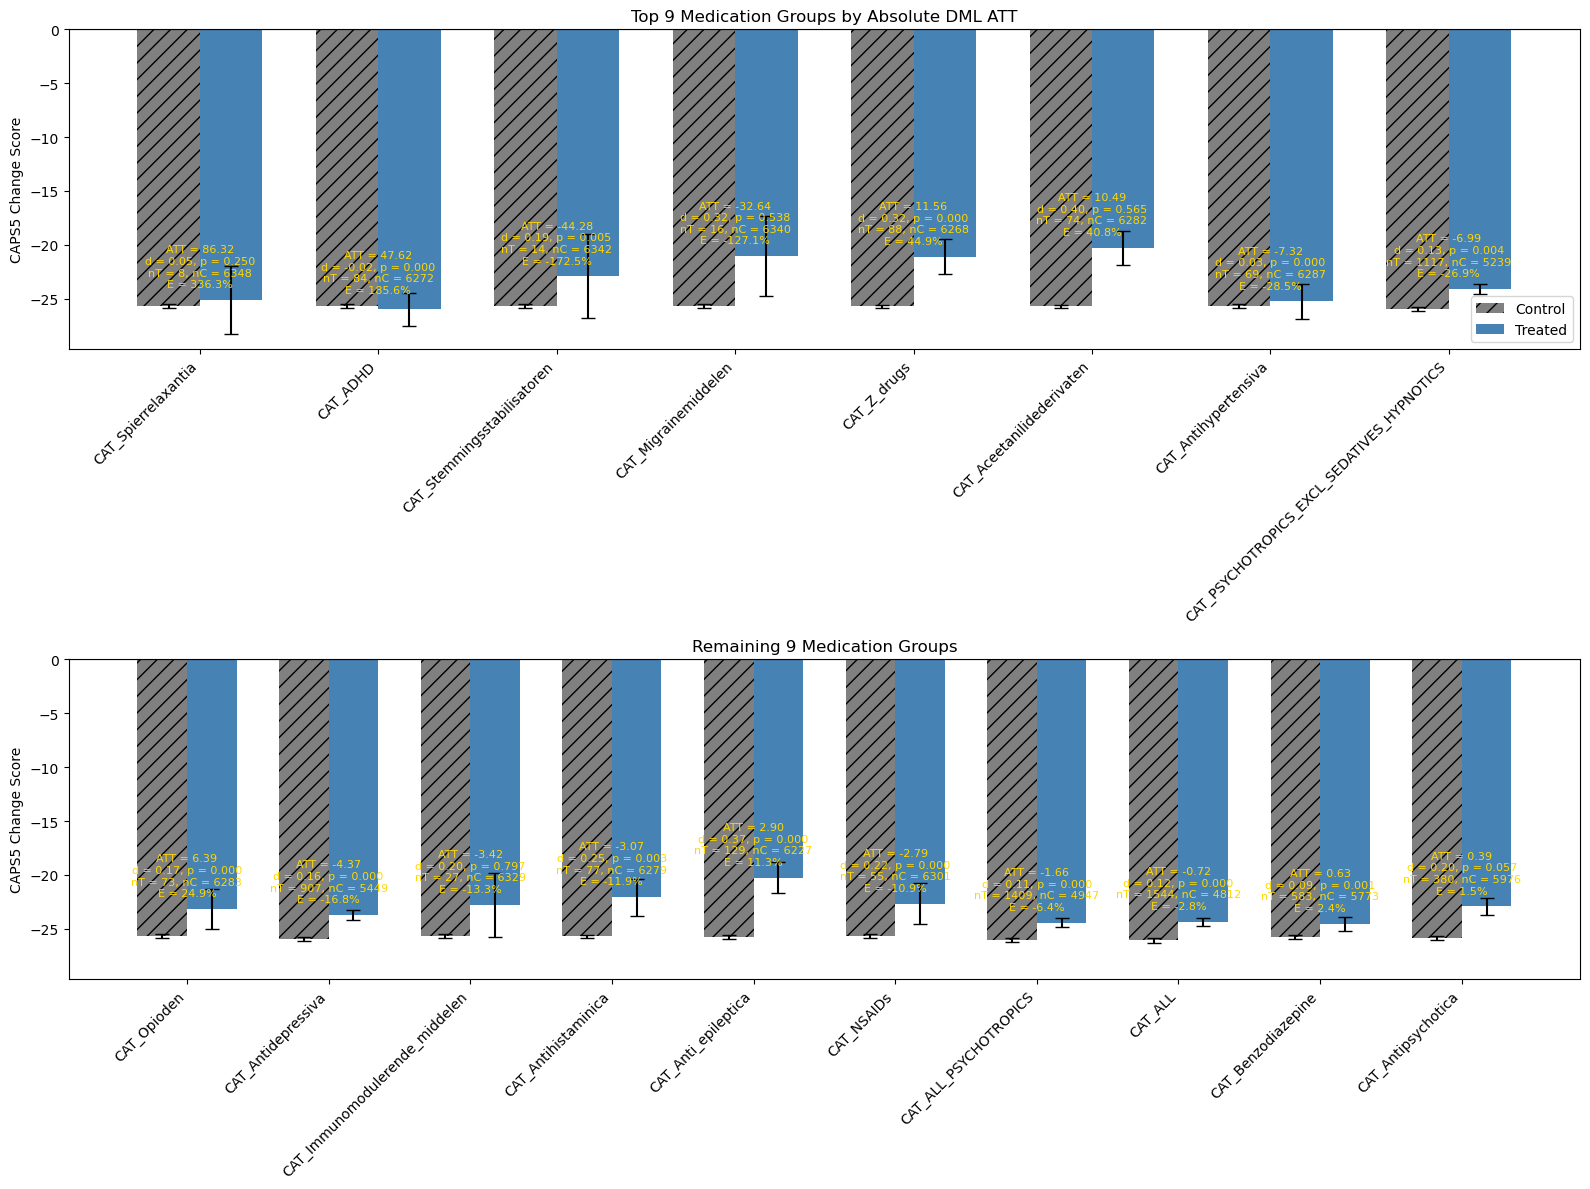

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Sort top 15 medication groups by absolute DML ATT
df_plot = final_df.sort_values(by='DML ATT', key=np.abs, ascending=False).reset_index(drop=True)

# Split into top 8 and bottom 7
df_top = df_plot.iloc[:8].reset_index(drop=True)
df_bottom = df_plot.iloc[8:].reset_index(drop=True)

# Plot settings
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharey=True)

# Function to create bar chart with annotation
def plot_group(ax, df_sub):
    x = np.arange(len(df_sub))

    bars1 = ax.bar(x - width/2, df_sub['Mean Control'], width, 
                   yerr=df_sub['SE Control'], label='Control', hatch='//', color='gray', capsize=5)
    bars2 = ax.bar(x + width/2, df_sub['Mean Treated'], width, 
                   yerr=df_sub['SE Treated'], label='Treated', color='steelblue', capsize=5)

    for i, row in df_sub.iterrows():
        label = (
            f"ATT = {row['DML ATT']:.2f}\n"
            f"d = {row['Cohen d']:.2f}, p = {row['DML p-value']:.3f}\n"
            f"nT = {row['n Treated']}, nC = {row['n Control']}\n"
            f"E = {row['E (DML-adjusted)']:.1f}%"
        )
        ax.text(i, max(row['Mean Control'], row['Mean Treated']) + 1, label,
                ha='center', va='bottom', fontsize=8, color='#FFD701')

    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(df_sub['Medication Group'], rotation=45, ha='right')

# Top 8 groups
plot_group(ax1, df_top)
ax1.set_title("Top 9 Medication Groups by Absolute DML ATT")
ax1.set_ylabel("CAPS5 Change Score")
ax1.legend()

# Bottom 7 groups
plot_group(ax2, df_bottom)
ax2.set_title("Remaining 9 Medication Groups")
ax2.set_ylabel("CAPS5 Change Score")

plt.tight_layout()

# ✅ Save the figure
plt.savefig("dml_att_barplot.png", dpi=300, bbox_inches='tight')

plt.show()


In [47]:
# Love plot:

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Functions to calculate balance
# -------------------------------
def calculate_smd(x1, x2, w1=None, w2=None):
    def weighted_mean(x, w=None):
        return np.average(x, weights=w) if w is not None else np.mean(x)
    def weighted_var(x, w=None):
        if w is not None:
            mean = np.average(x, weights=w)
            return np.average((x - mean) ** 2, weights=w)
        return np.var(x, ddof=1)
    m1, v1 = weighted_mean(x1, w1), weighted_var(x1, w1)
    m2, v2 = weighted_mean(x2, w2), weighted_var(x2, w2)
    pooled_sd = np.sqrt((v1 + v2) / 2)
    return np.abs(m1 - m2) / pooled_sd if pooled_sd > 0 else 0

def variance_ratio(x1, x2, w1=None, w2=None):
    def weighted_var(x, w=None):
        if w is not None:
            mean = np.average(x, weights=w)
            return np.average((x - mean) ** 2, weights=w)
        return np.var(x, ddof=1)
    v1 = weighted_var(x1, w1)
    v2 = weighted_var(x2, w2)
    return max(v1 / v2, v2 / v1) if v1 > 0 and v2 > 0 else 1

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("final_prepared_data.csv")

# -------------------------------
# Medication groups
# -------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# -------------------------------
# Load hardcoded covariates
# -------------------------------
from collections import defaultdict

final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# -------------------------------
# Main Loop
# -------------------------------
for group in medication_groups:
    print(f"\n🔍 Processing {group}...")

    try:
        output_folder = os.path.join("outputs", group)
        ps_path = os.path.join(output_folder, f"propensity_scores_{group}_composite.xlsx")

        if not os.path.exists(ps_path):
            print(f"⚠️ Missing propensity score file for {group}. Skipping.")
            continue

        ps_df = pd.read_excel(ps_path)
        ps_col = f"ps_{group}_composite"
        if ps_col not in ps_df.columns:
            print(f"❌ Composite PS column not found in {ps_path}")
            continue

        df["propensity_score"] = ps_df[ps_col]
        T = df[group]
        W = df["propensity_score"]

        # IPTW Weights
        p_treat = T.mean()
        p_control = 1 - p_treat
        weights = (p_treat / W) * T + (p_control / (1 - W)) * (1 - T)
        weights = weights.clip(lower=0.01, upper=10)

        covariates = final_covariates_map[group] + ['propensity_score']
        smd_unw, smd_w, vr_unw, vr_w, severity = [], [], [], [], []

        for cov in covariates:
            x1, x0 = df.loc[T == 1, cov], df.loc[T == 0, cov]
            w1, w0 = weights[T == 1], weights[T == 0]
            su = calculate_smd(x1, x0)
            sw = calculate_smd(x1, x0, w1, w0)
            vu = variance_ratio(x1, x0)
            vw = variance_ratio(x1, x0, w1, w0)

            smd_unw.append(su)
            smd_w.append(sw)
            vr_unw.append(vu)
            vr_w.append(vw)

            if sw <= 0.1:
                severity.append("Good")
            elif sw <= 0.2:
                severity.append("Moderate")
            else:
                severity.append("Poor")

        labels = [c if c != "propensity_score" else "Propensity Score" for c in covariates]

        numeric_df = pd.DataFrame({
            "Covariate": labels,
            "SMD_Unweighted": smd_unw,
            "SMD_Weighted": smd_w,
            "Imbalance_Severity": severity,
            "VR_Unweighted": vr_unw,
            "VR_Weighted": vr_w
        })
        numeric_path = os.path.join(output_folder, f"covariate_balance_table_{group}.xlsx")
        numeric_df.to_excel(numeric_path, index=False)
        print(f"📊 Exported numeric summary to: {numeric_path}")

        # Love Plot
        fig, axes = plt.subplots(1, 2, figsize=(18, len(labels) * 0.45))
        y_pos = np.arange(len(labels))

        axes[0].scatter(smd_unw, y_pos, color='red', label="Unweighted")
        axes[0].scatter(smd_w, y_pos, color='blue', label="Weighted")

        # Overplot severity highlights
        added_labels = set()
        for i, sw in enumerate(smd_w):
            if severity[i] == "Moderate":
                label = "Moderate" if "Moderate" not in added_labels else None
                axes[0].scatter(sw, y_pos[i], color='orange', s=100, label=label)
                added_labels.add("Moderate")
            elif severity[i] == "Poor":
                label = "Poor" if "Poor" not in added_labels else None
                axes[0].scatter(sw, y_pos[i], color='gold', edgecolors='black', s=100, label=label)
                added_labels.add("Poor")

        axes[0].axvline(0.1, color='gray', linestyle='--', label="Threshold 0.1")
        axes[0].axvline(0.2, color='black', linestyle='--', label="Threshold 0.2")
        axes[0].set_xlim(0, max(max(smd_unw), max(smd_w), 0.25) + 0.05)
        axes[0].set_yticks(y_pos)
        axes[0].set_yticklabels(labels)
        axes[0].invert_yaxis()
        axes[0].set_title("Standardized Mean Differences (SMD)")
        # Add dummy points for severity definitions in legend
        axes[0].scatter([], [], color='gold', edgecolors='black', s=100, label="Poor (SMD > 0.2)")
        axes[0].scatter([], [], color='orange', s=100, label="Moderate (0.1 < SMD ≤ 0.2)")
        axes[0].scatter([], [], color='green', s=100, label="Good (SMD ≤ 0.1)")

        axes[0].legend(loc="upper right")

        axes[0].grid(True)

        axes[1].scatter(vr_unw, y_pos, color='red', label="Unweighted", marker='o')
        axes[1].scatter(vr_w, y_pos, color='blue', label="Weighted", marker='x')
        axes[1].set_title("Variance Ratio (VR)")
        axes[1].axvline(2, color='gray', linestyle='--')
        axes[1].axvline(0.5, color='gray', linestyle='--')
        axes[1].set_xlim(0, max(max(vr_unw), max(vr_w), 2.5) + 0.5)
        axes[1].set_yticks(y_pos)
        axes[1].set_yticklabels([])
        axes[1].invert_yaxis()
        axes[1].legend()
        axes[1].grid(True)

        fig.suptitle(f"Covariate Balance for {group.replace('CAT_', '')}", fontsize=14, weight='bold')
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plot_path = os.path.join(output_folder, f"love_plot_{group}.png")
        fig.savefig(plot_path, dpi=300)
        plt.close()
        print(f"✅ Saved love plot: {plot_path}")

        print(f"📏 Max weighted SMD for {group}: {np.max(smd_w):.3f}")

    except Exception as e:
        print(f"❌ Error in {group}: {e}")



🔍 Processing CAT_Antipsychotica...
📊 Exported numeric summary to: outputs\CAT_Antipsychotica\covariate_balance_table_CAT_Antipsychotica.xlsx
✅ Saved love plot: outputs\CAT_Antipsychotica\love_plot_CAT_Antipsychotica.png
📏 Max weighted SMD for CAT_Antipsychotica: 0.372

🔍 Processing CAT_Antidepressiva...
📊 Exported numeric summary to: outputs\CAT_Antidepressiva\covariate_balance_table_CAT_Antidepressiva.xlsx
✅ Saved love plot: outputs\CAT_Antidepressiva\love_plot_CAT_Antidepressiva.png
📏 Max weighted SMD for CAT_Antidepressiva: 1.591

🔍 Processing CAT_Stemmingsstabilisatoren...
📊 Exported numeric summary to: outputs\CAT_Stemmingsstabilisatoren\covariate_balance_table_CAT_Stemmingsstabilisatoren.xlsx
✅ Saved love plot: outputs\CAT_Stemmingsstabilisatoren\love_plot_CAT_Stemmingsstabilisatoren.png
📏 Max weighted SMD for CAT_Stemmingsstabilisatoren: 1.241

🔍 Processing CAT_Benzodiazepine...
📊 Exported numeric summary to: outputs\CAT_Benzodiazepine\covariate_balance_table_CAT_Benzodiazepine

In [49]:
# Heatmap:

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import defaultdict

# -------------------------------
# Medication Groups (Composite PS)
# -------------------------------
medication_groups = [
    'CAT_Antipsychotica', 'CAT_Antidepressiva', 'CAT_Stemmingsstabilisatoren',
    'CAT_Benzodiazepine', 'CAT_Z_drugs', 'CAT_NSAIDs', 'CAT_ADHD',
    'CAT_Antihypertensiva', 'CAT_Antihistaminica', 'CAT_Anti_epileptica',
    'CAT_Opioden', 'CAT_Aceetanilidederivaten', 'CAT_Immunomodulerende_middelen',
    'CAT_Migrainemiddelen', 'CAT_Spierrelaxantia',
    'CAT_ALL', 'CAT_ALL_PSYCHOTROPICS', 'CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'
]

# -------------------------------
# Finalized Covariates Map
# -------------------------------
final_covariates_map = defaultdict(list)
final_covariates_map['CAT_ADHD'] = covariates_cat_adhd
final_covariates_map['CAT_Aceetanilidederivaten'] = covariates_cat_acet
final_covariates_map['CAT_Z_drugs'] = covariates_cat_zdrugs
final_covariates_map['CAT_Stemmingsstabilisatoren'] = covariates_cat_stemmingsstabilisatoren
final_covariates_map['CAT_Spierrelaxantia'] = covariates_cat_spierrelaxantia
final_covariates_map['CAT_Opioden'] = covariates_cat_opioden
final_covariates_map['CAT_NSAIDs'] = covariates_cat_nsaids
final_covariates_map['CAT_Migrainemiddelen'] = covariates_cat_migrainemiddelen
final_covariates_map['CAT_Immunomodulerende_middelen'] = covariates_cat_immunomodulerende_middelen
final_covariates_map['CAT_Benzodiazepine'] = covariates_cat_benzodiazepine
final_covariates_map['CAT_Antihypertensiva'] = covariates_cat_antihypertensiva
final_covariates_map['CAT_Antihistaminica'] = covariates_cat_antihistaminica
final_covariates_map['CAT_Anti_epileptica'] = covariates_cat_anti_epileptica
final_covariates_map['CAT_Antidepressiva'] = covariates_cat_antidepressiva
final_covariates_map['CAT_Antipsychotica'] = covariates_cat_antipsychotica
final_covariates_map['CAT_ALL'] = covariates_cat_all
final_covariates_map['CAT_ALL_PSYCHOTROPICS'] = covariates_cat_all_psychotropics
final_covariates_map['CAT_PSYCHOTROPICS_EXCL_SEDATIVES_HYPNOTICS'] = covariates_cat_psychotropics_excl_sedatives_hypnotics

# -------------------------------
# Generate heatmap for each group
# -------------------------------
for treatment_var in medication_groups:
    print(f"\n========== Creating Composite PS SMD Heatmap for {treatment_var} ==========")

    try:
        output_folder = os.path.join('outputs', treatment_var)
        balance_path = os.path.join(output_folder, f'covariate_balance_table_{treatment_var}.xlsx')

        if not os.path.exists(balance_path):
            print(f"❌ Balance file not found: {balance_path}")
            continue

        balance_df = pd.read_excel(balance_path)

        # ✅ Use finalized covariates only (plus propensity_score)
        covariates = final_covariates_map[treatment_var] + ['propensity_score']
        balance_df = balance_df[balance_df['Covariate'].isin(covariates)]

        # ✅ Check for CAPS5score_baseline
        highlight_caps = 'CAPS5score_baseline' in balance_df['Covariate'].values

        # ✅ Prepare for heatmap
        heatmap_df = balance_df[['Covariate', 'SMD_Unweighted', 'SMD_Weighted']].copy()
        heatmap_df.columns = ['Covariate', 'Unweighted', 'Weighted']
        heatmap_df = heatmap_df.set_index('Covariate')
        heatmap_df = heatmap_df.sort_values(by='Unweighted', ascending=False)

        # ✅ Plot
        plt.figure(figsize=(12, max(10, len(heatmap_df) * 0.35)))
        ax = sns.heatmap(
            heatmap_df,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            linewidths=0.6,
            linecolor='gray',
            cbar_kws={"label": "Standardized Mean Difference"}
        )

        plt.title(f"Covariate Balance Heatmap (Composite PS)\n{treatment_var}", fontsize=15, weight='bold')
        plt.xlabel("Condition")
        plt.ylabel("Covariate")

        # ✅ Bold CAPS5score_baseline if present
        if highlight_caps:
            ylabels = [label.get_text() for label in ax.get_yticklabels()]
            ax.set_yticklabels([
                f"{label} ←" if label == 'CAPS5score_baseline' else label for label in ylabels
            ])

        plt.tight_layout()

        # ✅ Save image
        save_path = os.path.join(output_folder, f'heatmap_smd_{treatment_var}.png')
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"✅ Heatmap saved: {save_path}")

    except Exception as e:
        print(f"⚠️ Error processing {treatment_var}: {e}")



========== Creating Composite PS SMD Heatmap for CAT_Antipsychotica ==========
✅ Heatmap saved: outputs\CAT_Antipsychotica\heatmap_smd_CAT_Antipsychotica.png

========== Creating Composite PS SMD Heatmap for CAT_Antidepressiva ==========
✅ Heatmap saved: outputs\CAT_Antidepressiva\heatmap_smd_CAT_Antidepressiva.png

========== Creating Composite PS SMD Heatmap for CAT_Stemmingsstabilisatoren ==========
✅ Heatmap saved: outputs\CAT_Stemmingsstabilisatoren\heatmap_smd_CAT_Stemmingsstabilisatoren.png

========== Creating Composite PS SMD Heatmap for CAT_Benzodiazepine ==========
✅ Heatmap saved: outputs\CAT_Benzodiazepine\heatmap_smd_CAT_Benzodiazepine.png

========== Creating Composite PS SMD Heatmap for CAT_Z_drugs ==========
✅ Heatmap saved: outputs\CAT_Z_drugs\heatmap_smd_CAT_Z_drugs.png

========== Creating Composite PS SMD Heatmap for CAT_NSAIDs ==========
✅ Heatmap saved: outputs\CAT_NSAIDs\heatmap_smd_CAT_NSAIDs.png

========== Creating Composite PS SMD Heatmap for CAT_ADHD =====

In [51]:
# Primary analysis:

In [52]:
# 🧠 Pick all CAT_ or SUBCAT_ medication indicators
medication_cols = [col for col in df.columns if col.startswith("CAT_") or col.startswith("SUBCAT_")]

# ✅ Create ANY_MEDICATION column: 1 if took anything, 0 if took nothing
df["ANY_MEDICATION"] = (df[medication_cols].sum(axis=1) > 0).astype(int)

# ✅ Remove CAPS5Score_TK from covariates if present
if "CAPS5Score_TK" in df.columns:
    df = df.drop(columns=["CAPS5Score_TK"])

# ✅ Create primary_analysis folder
os.makedirs("outputs/primary_analysis", exist_ok=True)


In [53]:
df["ANY_MEDICATION"]

0       0
1       1
2       0
3       1
4       0
       ..
6351    0
6352    1
6353    1
6354    1
6355    1
Name: ANY_MEDICATION, Length: 6356, dtype: int32

In [54]:
import os
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

# -------------------------------
# 0. Preprocessing
# -------------------------------
# Load your dataframe if not already loaded:
# df = pd.read_csv("final_prepared_data.csv")

# ✅ Drop CAPS5Score_TK if exists
if "CAPS5Score_TK" in df.columns:
    df = df.drop(columns=["CAPS5Score_TK"])

# -------------------------------
# 1. Define columns
# -------------------------------
outcome_col = 'caps5_change_baseline'
treatment_col = 'ANY_MEDICATION'

# Drop all CAT_ and SUBCAT_ columns from covariates
medication_cols = [col for col in df.columns if col.startswith('CAT_') or col.startswith('SUBCAT_')]
exclude_cols = medication_cols + [outcome_col, treatment_col]
covariate_cols = [col for col in df.columns if col not in exclude_cols]

X_raw = df[covariate_cols].copy()
Y_raw = df[[outcome_col]]
T_raw = df[[treatment_col]]

# ✅ Save to primary_analysis instead
output_dir = f"outputs/primary_analysis/{treatment_col}"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------
# 2. Perform multiple imputations
# -------------------------------
n_imputations = 5
all_weights = []

for imp_num in range(1, n_imputations + 1):
    print(f"🔁 Imputation {imp_num}...")

    # Impute covariates
    imputer = IterativeImputer(random_state=imp_num)
    X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=covariate_cols)

    # Keep only rows without missing Y or T
    complete_mask = (~Y_raw[outcome_col].isna()) & (~T_raw[treatment_col].isna()) & (~X_imp.isna().any(axis=1))
    X_final = X_imp.loc[complete_mask].copy()
    Y_final = Y_raw.loc[complete_mask].copy()
    T_final = T_raw.loc[complete_mask].copy()

    # Save imputed matrices
    X_final.to_csv(f"{output_dir}/X_matrix_imputed_{treatment_col}_imp{imp_num}.csv", index=False)
    full_df = pd.concat([X_final, Y_final, T_final], axis=1)
    full_df.to_csv(f"{output_dir}/df_{treatment_col}_imp{imp_num}.csv", index=False)

    # -------------------------------
    # 3. Estimate Propensity Scores & IPTW Weights
    # -------------------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_scaled, T_final.values.ravel())
    ps = model.predict_proba(X_scaled)[:, 1]  # P(T=1 | X)

    p_treat = T_final.mean().values[0]
    p_control = 1 - p_treat

    weights = (p_treat / ps) * T_final.values.ravel() + (p_control / (1 - ps)) * (1 - T_final.values.ravel())
    weights = np.clip(weights, 0.01, 10)

    all_weights.append(pd.DataFrame({
        treatment_col: T_final.values.ravel(),
        f'iptw_weight_{treatment_col}_rubin': weights
    }))

# -------------------------------
# 4. Save Rubin-style IPTW weight file
# -------------------------------
iptw_concat = pd.concat(all_weights).reset_index(drop=True)
iptw_concat.to_excel(f"{output_dir}/iptw_weights_{treatment_col}_RUBIN.xlsx", index=False)

print("✅ Imputed data and IPTW weights saved.")


🔁 Imputation 1...
🔁 Imputation 2...
🔁 Imputation 3...
🔁 Imputation 4...
🔁 Imputation 5...
✅ Imputed data and IPTW weights saved.


In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t, probplot
import statsmodels.api as sm

# ----------------------------------------------------
# Rubin’s Rule function
# ----------------------------------------------------
def rubins_pool(estimates, ses):
    m = len(estimates)
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    p_value = 2 * (1 - t.cdf(np.abs(q_bar / total_se), df=m - 1))
    return q_bar, total_se, ci_lower, ci_upper, p_value

def calculate_smd_vr(X, T):
    smd_list, vr_list = [], []
    for col in X.columns:
        x1, x0 = X.loc[T == 1, col], X.loc[T == 0, col]
        m1, m0 = x1.mean(), x0.mean()
        v1, v0 = x1.var(ddof=1), x0.var(ddof=1)
        smd = np.abs(m1 - m0) / np.sqrt((v1 + v0) / 2) if (v1 + v0) > 0 else np.nan
        vr = v1 / v0 if v0 > 0 else np.nan
        smd_list.append(smd)
        vr_list.append(vr)
    return np.mean(smd_list), np.mean(vr_list)

# ----------------------------------------------------
# Configuration
# ----------------------------------------------------
treatment_var = "ANY_MEDICATION"
outcome_var = "caps5_change_baseline"
n_imputations = 5
n_repeats = 4

results = []
residuals_all = []
smd_list_all, vr_list_all = [], []

# ----------------------------------------------------
# Run Rubin’s Rule + Repeated DML
# ----------------------------------------------------
att_list, se_list, rmse_list, r2_list = [], [], [], []

for imp in range(1, n_imputations + 1):
    try:
        base_path = f"outputs/primary_analysis/{treatment_var}"
        os.makedirs(base_path, exist_ok=True)

        x_path = f"{base_path}/X_matrix_imputed_{treatment_var}_imp{imp}.csv"
        y_path = f"{base_path}/df_{treatment_var}_imp{imp}.csv"
        w_path = f"{base_path}/iptw_weights_{treatment_var}_RUBIN.xlsx"

        if not all(os.path.exists(p) for p in [x_path, y_path, w_path]):
            print(f"❌ Missing files for imputation {imp}")
            continue

        X = pd.read_csv(x_path)
        df_full = pd.read_csv(y_path)
        W_df = pd.read_excel(w_path)

        # ✅ Remove CAPS5Score_TK if present
        if "CAPS5Score_TK" in X.columns:
            X = X.drop(columns=["CAPS5Score_TK"])

        Y = df_full[outcome_var]
        T = W_df[treatment_var]
        W = W_df[f'iptw_weight_{treatment_var}_rubin']

        # Drop missing
        mask = (~Y.isna()) & (~T.isna()) & (~W.isna()) & (~X.isna().any(axis=1))
        X_sub, Y_sub, T_sub, W_sub = X[mask], Y[mask], T[mask], W[mask]

        for repeat in range(n_repeats):
            model_y = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
            model_t = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,
                                    use_label_encoder=False, eval_metric='logloss')
            dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True,
                            cv=KFold(n_splits=5, shuffle=True, random_state=repeat))
            dml.fit(Y_sub, T_sub, X=X_sub, sample_weight=W_sub)
            att = dml.ate(X_sub)

            # Robust SE from weighted OLS
            ols = sm.WLS(Y_sub, sm.add_constant(X_sub), weights=W_sub).fit(cov_type="HC3")
            se = ols.bse[1]

            # Model predictions
            Y_pred = model_y.fit(X_sub, Y_sub, sample_weight=W_sub).predict(X_sub)
            residuals = Y_sub - Y_pred
            residuals_all.extend(residuals)

            # Metrics
            rmse = mean_squared_error(Y_sub, Y_pred, squared=False)
            r2 = r2_score(Y_sub, Y_pred)
            smd, vr = calculate_smd_vr(X_sub, T_sub)

            # Collect results
            att_list.append(att)
            se_list.append(se)
            rmse_list.append(rmse)
            r2_list.append(r2)
            smd_list_all.append(smd)
            vr_list_all.append(vr)

            # Save residual plot
            plt.figure(figsize=(6, 4))
            plt.scatter(Y_pred, residuals, alpha=0.5)
            plt.axhline(y=0, color='red', linestyle='--')
            plt.xlabel('Predicted CAPS-5 Change')
            plt.ylabel('Residuals')
            plt.title(f'{treatment_var} | Imp {imp} Rep {repeat}')
            plt.tight_layout()
            plt.savefig(f"{base_path}/residual_plot_imp{imp}_rep{repeat}.png")
            plt.close()

    except Exception as e:
        print(f"⚠️ Error in imp {imp}: {e}")
        continue

# ----------------------------------------------------
# Rubin's pooling
# ----------------------------------------------------
if len(att_list) == n_imputations * n_repeats:
    att, se, ci_lo, ci_hi, p = rubins_pool(att_list, se_list)
    results.append([treatment_var, att, se, ci_lo, ci_hi, round(p, 5),
                    np.mean(rmse_list), np.mean(r2_list)])
    print(f"\n✅ PRIMARY ANALYSIS — ANY_MEDICATION")
    print(f"ATT = {att:.4f}, SE = {se:.4f}, 95% CI = [{ci_lo:.4f}, {ci_hi:.4f}], p = {p:.5f}")

    # Residual histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals_all, bins=30, kde=True)
    plt.title(f'{treatment_var} | Residual Distribution')
    plt.xlabel('Residuals')
    plt.tight_layout()
    plt.savefig(f"{base_path}/residual_distribution_all.png")
    plt.close()

    # QQ plot
    plt.figure(figsize=(6, 4))
    probplot(residuals_all, dist="norm", plot=plt)
    plt.title(f'{treatment_var} | QQ Plot')
    plt.tight_layout()
    plt.savefig(f"{base_path}/qqplot_residuals_all.png")
    plt.close()

    # Export final results
    pd.DataFrame(results, columns=[
        'Treatment', 'ATT', 'Robust SE', '95% CI Lower', '95% CI Upper',
        'P-value', 'RMSE', 'R²']
    ).to_excel(f"{base_path}/xgb_dml_rubin_summary_{treatment_var}.xlsx", index=False)

    pd.DataFrame([[treatment_var, np.mean(smd_list_all), np.mean(vr_list_all)]],
        columns=['Treatment', 'Average SMD', 'Average Variance Ratio']
    ).to_excel(f"{base_path}/smd_vr_summary_{treatment_var}.xlsx", index=False)

else:
    print(f"⚠️ Skipped due to insufficient imputations: {len(att_list)} / {n_imputations * n_repeats}")

print("\n📄 Primary analysis for 'Any medication vs. none' completed.")



✅ PRIMARY ANALYSIS — ANY_MEDICATION
ATT = 2.6547, SE = 0.7815, 95% CI = [1.1229, 4.1864], p = 0.00303

📄 Primary analysis for 'Any medication vs. none' completed.


In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t, probplot
import statsmodels.api as sm

# ----------------------------------------------------
# Rubin’s Rule function
# ----------------------------------------------------
def rubins_pool(estimates, ses):
    m = len(estimates)
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    p_value = 2 * (1 - t.cdf(np.abs(q_bar / total_se), df=m - 1))
    return q_bar, total_se, ci_lower, ci_upper, p_value

def calculate_smd_vr(X, T):
    smd_list, vr_list = [], []
    for col in X.columns:
        x1, x0 = X.loc[T == 1, col], X.loc[T == 0, col]
        m1, m0 = x1.mean(), x0.mean()
        v1, v0 = x1.var(ddof=1), x0.var(ddof=1)
        smd = np.abs(m1 - m0) / np.sqrt((v1 + v0) / 2) if (v1 + v0) > 0 else np.nan
        vr = v1 / v0 if v0 > 0 else np.nan
        smd_list.append(smd)
        vr_list.append(vr)
    return np.mean(smd_list), np.mean(vr_list)

# ----------------------------------------------------
# Configuration
# ----------------------------------------------------
treatment_var = "ANY_MEDICATION"
outcome_var = "caps5_change_baseline"
n_imputations = 5
n_repeats = 4

results = []
residuals_all = []
smd_list_all, vr_list_all = [], []

# ----------------------------------------------------
# Run Rubin’s Rule + Repeated DML (UNWEIGHTED)
# ----------------------------------------------------
att_list, se_list, rmse_list, r2_list = [], [], [], []

for imp in range(1, n_imputations + 1):
    try:
        base_path = f"outputs/primary_analysis/{treatment_var}_UNWEIGHTED"
        os.makedirs(base_path, exist_ok=True)

        x_path = f"outputs/primary_analysis/{treatment_var}/X_matrix_imputed_{treatment_var}_imp{imp}.csv"
        y_path = f"outputs/primary_analysis/{treatment_var}/df_{treatment_var}_imp{imp}.csv"

        if not all(os.path.exists(p) for p in [x_path, y_path]):
            print(f"❌ Missing files for imputation {imp}")
            continue

        X = pd.read_csv(x_path)
        df_full = pd.read_csv(y_path)

        # ✅ Remove CAPS5Score_TK if present
        if "CAPS5Score_TK" in X.columns:
            X = X.drop(columns=["CAPS5Score_TK"])

        Y = df_full[outcome_var]
        T = df_full[treatment_var]

        mask = (~Y.isna()) & (~T.isna()) & (~X.isna().any(axis=1))
        X_sub, Y_sub, T_sub = X[mask], Y[mask], T[mask]

        for repeat in range(n_repeats):
            model_y = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
            model_t = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,
                                    use_label_encoder=False, eval_metric='logloss')
            dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True,
                            cv=KFold(n_splits=5, shuffle=True, random_state=repeat))
            dml.fit(Y_sub, T_sub, X=X_sub)  # ❌ No sample_weight
            att = dml.ate(X_sub)

            # Unweighted SE via OLS
            ols = sm.OLS(Y_sub, sm.add_constant(X_sub)).fit(cov_type="HC3")
            se = ols.bse[1]

            Y_pred = model_y.fit(X_sub, Y_sub).predict(X_sub)
            residuals = Y_sub - Y_pred
            residuals_all.extend(residuals)

            rmse = mean_squared_error(Y_sub, Y_pred, squared=False)
            r2 = r2_score(Y_sub, Y_pred)
            smd, vr = calculate_smd_vr(X_sub, T_sub)

            att_list.append(att)
            se_list.append(se)
            rmse_list.append(rmse)
            r2_list.append(r2)
            smd_list_all.append(smd)
            vr_list_all.append(vr)

            # Save residual scatter plot
            plt.figure(figsize=(6, 4))
            plt.scatter(Y_pred, residuals, alpha=0.5)
            plt.axhline(y=0, color='red', linestyle='--')
            plt.xlabel('Predicted CAPS-5 Change')
            plt.ylabel('Residuals')
            plt.title(f'{treatment_var} (UNWEIGHTED) | Imp {imp} Rep {repeat}')
            plt.tight_layout()
            plt.savefig(f"{base_path}/residual_plot_imp{imp}_rep{repeat}.png")
            plt.close()

    except Exception as e:
        print(f"⚠️ Error in imputation {imp}: {e}")
        continue

# ----------------------------------------------------
# Pool and Save Results
# ----------------------------------------------------
if len(att_list) == n_imputations * n_repeats:
    att, se, ci_lo, ci_hi, p = rubins_pool(att_list, se_list)
    results.append([treatment_var, att, se, ci_lo, ci_hi, round(p, 5),
                    np.mean(rmse_list), np.mean(r2_list)])
    print(f"\n✅ UNWEIGHTED ANALYSIS — ANY_MEDICATION")
    print(f"ATT = {att:.4f}, SE = {se:.4f}, 95% CI = [{ci_lo:.4f}, {ci_hi:.4f}], p = {p:.5f}")

    # Residual histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals_all, bins=30, kde=True)
    plt.title(f'{treatment_var} (UNWEIGHTED) | Residual Distribution')
    plt.xlabel('Residuals')
    plt.tight_layout()
    plt.savefig(f"{base_path}/residual_distribution_all.png")
    plt.close()

    # QQ plot
    plt.figure(figsize=(6, 4))
    probplot(residuals_all, dist="norm", plot=plt)
    plt.title(f'{treatment_var} (UNWEIGHTED) | QQ Plot')
    plt.tight_layout()
    plt.savefig(f"{base_path}/qqplot_residuals_all.png")
    plt.close()

    # Export final results
    pd.DataFrame(results, columns=[
        'Treatment', 'ATT', 'Robust SE', '95% CI Lower', '95% CI Upper',
        'P-value', 'RMSE', 'R²']
    ).to_excel(f"{base_path}/xgb_dml_rubin_summary_{treatment_var}_UNWEIGHTED.xlsx", index=False)

    pd.DataFrame([[treatment_var, np.mean(smd_list_all), np.mean(vr_list_all)]],
        columns=['Treatment', 'Average SMD', 'Average Variance Ratio']
    ).to_excel(f"{base_path}/smd_vr_summary_{treatment_var}_UNWEIGHTED.xlsx", index=False)

else:
    print(f"⚠️ Skipped due to insufficient imputations: {len(att_list)} / {n_imputations * n_repeats}")

print("\n📄 Unweighted IPTW-free analysis for 'Any medication vs. none' completed.")



✅ UNWEIGHTED ANALYSIS — ANY_MEDICATION
ATT = 2.1344, SE = 0.6775, 95% CI = [0.8065, 3.4624], p = 0.00527

📄 Unweighted IPTW-free analysis for 'Any medication vs. none' completed.


In [57]:
import pandas as pd

# Load both result files
weighted = pd.read_excel("xgb_dml_rubin_summary_ANY_MEDICATION.xlsx")
unweighted = pd.read_excel("xgb_dml_rubin_summary_ANY_MEDICATION_UNWEIGHTED.xlsx")

# Rename columns to distinguish
weighted = weighted.add_suffix('_WEIGHTED')
unweighted = unweighted.add_suffix('_UNWEIGHTED')

# Merge side-by-side
comparison_df = pd.concat([weighted, unweighted], axis=1)

# Reorder for clarity
comparison_df = comparison_df[[
    'Treatment_WEIGHTED', 'ATT_WEIGHTED', 'ATT_UNWEIGHTED',
    'Robust SE_WEIGHTED', 'Robust SE_UNWEIGHTED',
    '95% CI Lower_WEIGHTED', '95% CI Lower_UNWEIGHTED',
    '95% CI Upper_WEIGHTED', '95% CI Upper_UNWEIGHTED',
    'P-value_WEIGHTED', 'P-value_UNWEIGHTED',
    'RMSE_WEIGHTED', 'RMSE_UNWEIGHTED',
    'R²_WEIGHTED', 'R²_UNWEIGHTED'
]]

# Save comparison table
comparison_df.to_excel("comparison_ANY_MEDICATION_weighted_vs_unweighted.xlsx", index=False)

print("✅ Comparison saved to 'comparison_ANY_MEDICATION_weighted_vs_unweighted.xlsx'")


✅ Comparison saved to 'comparison_ANY_MEDICATION_weighted_vs_unweighted.xlsx'


In [58]:
import os
import numpy as np
import pandas as pd

# Configuration
base_path = "outputs/primary_analysis/ANY_MEDICATION"
n_imputations = 5
outcome_col = "caps5_change_baseline"
treatment_col = "ANY_MEDICATION"
weight_col = "iptw_weight_ANY_MEDICATION_rubin"

# Initialize Rubin’s rule input containers
group_stats_all = {
    'treated_unw': [],
    'control_unw': [],
    'treated_w': [],
    'control_w': []
}

# Rubin’s Rule pooling function
def rubins_pool(estimates, ses):
    m = len(estimates)
    if m == 0:
        return np.nan, np.nan, np.nan, np.nan
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    return q_bar, total_se, ci_lower, ci_upper

# Helper function to compute mean, SD, SE
def get_group_stats(values, weights=None):
    if len(values) == 0:
        return None
    if weights is None:
        mean = values.mean()
        var = values.var(ddof=1)
    else:
        mean = np.average(values, weights=weights)
        var = np.average((values - mean)**2, weights=weights)
    se = np.sqrt(var / len(values))
    return mean, np.sqrt(var), se

# Loop over imputations
for imp in range(1, n_imputations + 1):
    df_path = f"{base_path}/df_ANY_MEDICATION_imp{imp}.csv"
    weight_path = f"{base_path}/iptw_weights_ANY_MEDICATION_RUBIN.xlsx"

    if not os.path.exists(df_path) or not os.path.exists(weight_path):
        print(f"⚠️ Skipping imputation {imp} due to missing files.")
        continue

    df = pd.read_csv(df_path)
    iptw = pd.read_excel(weight_path)

    if "CAPS5Score_TK" in df.columns:
        df = df.drop(columns=["CAPS5Score_TK"])

    df[treatment_col] = iptw[treatment_col]
    df["iptw_weight"] = iptw[weight_col]

    Y = df[outcome_col]
    T = df[treatment_col]
    W = df["iptw_weight"]

    for group, label in [(1, 'treated_unw'), (0, 'control_unw')]:
        vals = Y[T == group]
        stats = get_group_stats(vals)
        if stats is not None:
            group_stats_all[label].append((stats[0], stats[2]))  # (mean, se)

    for group, label in [(1, 'treated_w'), (0, 'control_w')]:
        vals = Y[T == group]
        weights = W[T == group]
        stats = get_group_stats(vals, weights=weights)
        if stats is not None:
            group_stats_all[label].append((stats[0], stats[2]))  # (mean, se)

# Pool via Rubin’s Rule
summary_rows = []
for label, stats in group_stats_all.items():
    means = [s[0] for s in stats if s is not None]
    ses = [s[1] for s in stats if s is not None]
    mean, se, ci_lo, ci_hi = rubins_pool(means, ses)
    summary_rows.append([
        label.replace('_', ' ').title(),
        outcome_col,
        mean,
        '',  # SD not pooled
        se,
        ci_lo,
        ci_hi,
        '',  # R²
        ''   # RMSE
    ])

# Load Rubin-pooled ATT from XGBoost DML results
att_df_path = f"{base_path}/xgb_dml_rubin_summary_ANY_MEDICATION.xlsx"
if os.path.exists(att_df_path):
    att_df = pd.read_excel(att_df_path)
    att_row = [
        "XGBoost DML ATT (Rubin's Pooled)",
        outcome_col,
        att_df['ATT'][0],
        '',  # SD
        att_df['Robust SE'][0],
        att_df['95% CI Lower'][0],
        att_df['95% CI Upper'][0],
        att_df['R²'][0],
        att_df['RMSE'][0]
    ]
    summary_rows.append([''] * 9)  # separator row
    summary_rows.append(att_row)
else:
    print("⚠️ ATT results file missing.")

# Export to Excel
columns = ['Group', 'Variable', 'Mean', 'SD', 'SE', '95% CI Lower', '95% CI Upper', 'R²', 'RMSE']
summary_df = pd.DataFrame(summary_rows, columns=columns)

output_file = f"{base_path}/ANY_MEDICATION_analysis_summary_table_rubinpooled.xlsx"
summary_df.to_excel(output_file, index=False)

print(f"✅ Rubin-pooled summary table saved to '{output_file}'")


✅ Rubin-pooled summary table saved to 'outputs/primary_analysis/ANY_MEDICATION/ANY_MEDICATION_analysis_summary_table_rubinpooled.xlsx'


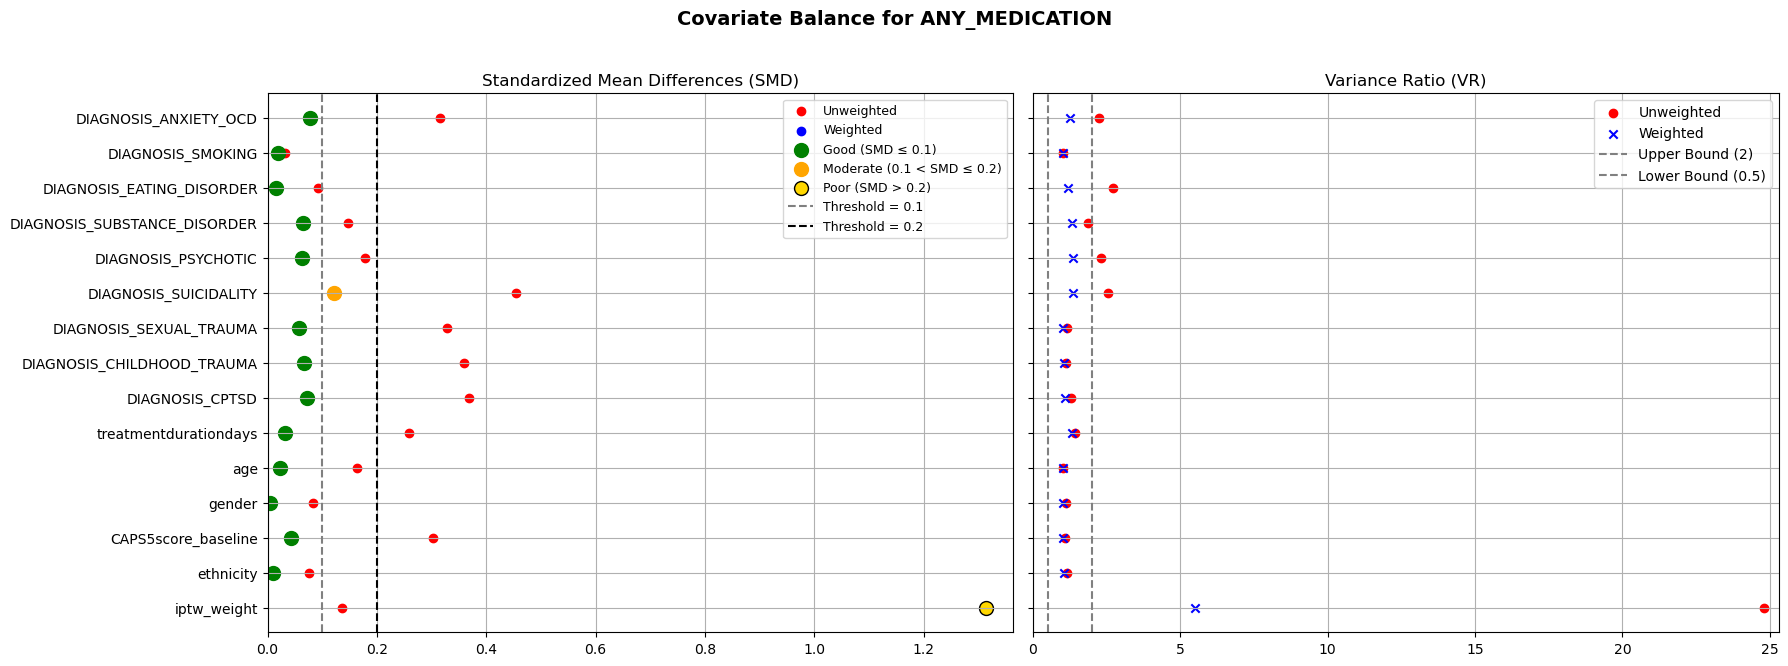

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("final_prepared_data.csv")
iptw_df = pd.read_excel("outputs/primary_analysis/ANY_MEDICATION/iptw_weights_ANY_MEDICATION_RUBIN.xlsx")

# Merge treatment and weights
df["ANY_MEDICATION"] = iptw_df["ANY_MEDICATION"]
df["iptw_weight"] = iptw_df["iptw_weight_ANY_MEDICATION_rubin"]

outcome_col = "caps5_change_baseline"
treatment_col = "ANY_MEDICATION"

# Drop CAT_ and SUBCAT_ medication variables from covariates
medication_cols = [col for col in df.columns if col.startswith("CAT_") or col.startswith("SUBCAT_")]
exclude_cols = [outcome_col, treatment_col] + medication_cols

# ✅ Remove CAPS5Score_TK if present
if "CAPS5Score_TK" in df.columns:
    exclude_cols.append("CAPS5Score_TK")

covariates = [col for col in df.columns if col not in exclude_cols]

# -------------------------------
# Balance functions
# -------------------------------
def calculate_smd(x1, x2, w1=None, w2=None):
    def weighted_mean(x, w): return np.average(x, weights=w) if w is not None else np.mean(x)
    def weighted_var(x, w): return np.average((x - weighted_mean(x, w))**2, weights=w) if w is not None else np.var(x, ddof=1)
    m1, v1 = weighted_mean(x1, w1), weighted_var(x1, w1)
    m2, v2 = weighted_mean(x2, w2), weighted_var(x2, w2)
    pooled_sd = np.sqrt((v1 + v2) / 2)
    return np.abs(m1 - m2) / pooled_sd if pooled_sd > 0 else 0

def calculate_vr(x1, x2, w1=None, w2=None):
    def weighted_var(x, w): return np.average((x - np.average(x, weights=w))**2, weights=w) if w is not None else np.var(x, ddof=1)
    v1, v2 = weighted_var(x1, w1), weighted_var(x2, w2)
    return max(v1 / v2, v2 / v1) if v1 > 0 and v2 > 0 else np.nan

# -------------------------------
# Compute balance stats
# -------------------------------
T = df[treatment_col]
W = df["iptw_weight"]

smd_unw, smd_w, vr_unw, vr_w, severity, labels = [], [], [], [], [], []

for cov in covariates:
    x1, x0 = df.loc[T == 1, cov], df.loc[T == 0, cov]
    w1, w0 = W[T == 1], W[T == 0]

    su = calculate_smd(x1, x0)
    sw = calculate_smd(x1, x0, w1, w0)
    vu = calculate_vr(x1, x0)
    vw = calculate_vr(x1, x0, w1, w0)

    smd_unw.append(su)
    smd_w.append(sw)
    vr_unw.append(vu)
    vr_w.append(vw)

    if sw <= 0.1:
        severity.append("Good")
    elif sw <= 0.2:
        severity.append("Moderate")
    else:
        severity.append("Poor")

    labels.append(cov)

# -------------------------------
# Plot Love Plot with VR
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, len(labels) * 0.45))
y_pos = np.arange(len(labels))

# SMD Plot
axes[0].scatter(smd_unw, y_pos, color='red', label="Unweighted")
axes[0].scatter(smd_w, y_pos, color='blue', label="Weighted")

for i, sev in enumerate(severity):
    if sev == "Good":
        axes[0].scatter(smd_w[i], y_pos[i], color='green', s=100, label="Good (SMD ≤ 0.1)" if "Good" not in severity[:i] else "")
    elif sev == "Moderate":
        axes[0].scatter(smd_w[i], y_pos[i], color='orange', s=100, label="Moderate (0.1 < SMD ≤ 0.2)" if "Moderate" not in severity[:i] else "")
    elif sev == "Poor":
        axes[0].scatter(smd_w[i], y_pos[i], color='gold', edgecolors='black', s=100, label="Poor (SMD > 0.2)" if "Poor" not in severity[:i] else "")

axes[0].axvline(0.1, color='gray', linestyle='--', label="Threshold = 0.1")
axes[0].axvline(0.2, color='black', linestyle='--', label="Threshold = 0.2")
axes[0].set_xlim(0, max(max(smd_unw), max(smd_w), 0.25) + 0.05)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(labels)
axes[0].invert_yaxis()
axes[0].set_title("Standardized Mean Differences (SMD)")
axes[0].legend(loc="upper right", fontsize=9)
axes[0].grid(True)

# VR Plot
axes[1].scatter(vr_unw, y_pos, color='red', label="Unweighted", marker='o')
axes[1].scatter(vr_w, y_pos, color='blue', label="Weighted", marker='x')
axes[1].axvline(2, color='gray', linestyle='--', label="Upper Bound (2)")
axes[1].axvline(0.5, color='gray', linestyle='--', label="Lower Bound (0.5)")
axes[1].set_xlim(0, max(max(vr_unw), max(vr_w), 2.5) + 0.5)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([])
axes[1].invert_yaxis()
axes[1].set_title("Variance Ratio (VR)")
axes[1].legend()
axes[1].grid(True)

fig.suptitle("Covariate Balance for ANY_MEDICATION", fontsize=14, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save
output_dir = "outputs/primary_analysis/ANY_MEDICATION"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(f"{output_dir}/love_plot_ANY_MEDICATION_FULL.png", dpi=300)
plt.show()


In [60]:
# Secondary analysis:

In [61]:
covariates_cat_antidepressiva = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antihistaminica', 'CAT_Antihypertensiva', 'CAT_Antipsychotica',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia', 'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen', 'SUBCAT_Antipsychotica_Klassiek',
    'SUBCAT_Antipsychotica_atypisch', 'SUBCAT_Anti_epileptica_GABA_analogon',
    'SUBCAT_Anti_epileptica_overig', 'SUBCAT_Anti_epileptica_stemmingsstabilisatoren',
    'SUBCAT_Clonidine', 'SUBCAT_NSAIDs', 'SUBCAT_Paracetamol_mono',
    'SUBCAT_SNRI', 'SUBCAT_SSRI', 'SUBCAT_Systemische_antihistaminica',
    'SUBCAT_Systemische_betablokkers', 'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]


covariates_cat_antipsychotica = [
    'treatmentdurationdays', 'CAPS5score_baseline',
    'CAT_ADHD', 'CAT_Aceetanilidederivaten', 'CAT_Anti_epileptica',
    'CAT_Antidepressiva', 'CAT_Antihistaminica', 'CAT_Antihypertensiva',
    'CAT_Benzodiazepine', 'CAT_Immunomodulerende_middelen', 'CAT_Migrainemiddelen',
    'CAT_NSAIDs', 'CAT_Opioden', 'CAT_Spierrelaxantia', 'CAT_Stemmingsstabilisatoren', 'CAT_Z_drugs',
    'DIAGNOSIS_CHILDHOOD_TRAUMA', 'DIAGNOSIS_CPTSD', 'DIAGNOSIS_SEXUAL_TRAUMA',
    'DIAGNOSIS_SMOKING', 'DIAGNOSIS_SUICIDALITY', 'age', 'ethnicity', 'gender',
    'SUBCAT_ACE_remmer', 'SUBCAT_Amfetaminen', 'SUBCAT_Antidepressiva_overige',
    'SUBCAT_Anti_epileptica_GABA_analogon', 'SUBCAT_Anti_epileptica_overig',
    'SUBCAT_Anti_epileptica_stemmingsstabilisatoren', 'SUBCAT_Clonidine',
    'SUBCAT_NSAIDs', 'SUBCAT_Paracetamol_mono', 'SUBCAT_SNRI', 'SUBCAT_SSRI',
    'SUBCAT_Systemische_antihistaminica', 'SUBCAT_Systemische_betablokkers',
    'SUBCAT_TCA', 'SUBCAT_TNF_alpha_blockers',
    'SUBCAT_anxiolytica_Benzodiazepine', 'SUBCAT_hypnotica_Benzodiazepine',
    'SUBCAT_Tetracyclische_antidepressiva', 'DIAGNOSIS_ANXIETY_OCD',
    'DIAGNOSIS_PSYCHOTIC',
    'DIAGNOSIS_EATING_DISORDER',
    'DIAGNOSIS_SUBSTANCE_DISORDER'
]



covariates_cat_sedatives = list(sorted(set(covariates_cat_benzodiazepine + covariates_cat_zdrugs)))


In [62]:
import os
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv("final_prepared_data.csv")

# -------------------------------
# Create CAT_SEDATIVES if missing
# -------------------------------
df["CAT_SEDATIVES"] = ((df["CAT_Benzodiazepine"] == 1) | (df["CAT_Z_drugs"] == 1)).astype(int)

# -------------------------------
# Covariate Map (ONLY for these 3)
# -------------------------------
covariates_map = {
    "CAT_Antidepressiva": covariates_cat_antidepressiva,
    "CAT_Antipsychotica": covariates_cat_antipsychotica,
    "CAT_SEDATIVES": covariates_cat_benzodiazepine  # since CAT_SEDATIVES = Benzos + Z-drugs
}

# -------------------------------
# Imputation + IPTW Loop
# -------------------------------
n_imputations = 5

for treatment_col in ["CAT_Antidepressiva", "CAT_Antipsychotica", "CAT_SEDATIVES"]:
    print(f"\n🔁 Processing: {treatment_col}")

    covariate_cols = covariates_map[treatment_col]
    outcome_col = "caps5_change_baseline"

    # Extract relevant data
    X_raw = df[covariate_cols].copy()
    Y_raw = df[[outcome_col]]
    T_raw = df[[treatment_col]]

    output_dir = f"outputs/secondary_analysis/{treatment_col}"
    os.makedirs(output_dir, exist_ok=True)
    all_weights = []

    for imp_num in range(1, n_imputations + 1):
        print(f"   ⏳ Imputation {imp_num}")

        # Impute covariates
        imputer = IterativeImputer(random_state=imp_num)
        X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=covariate_cols)

        # Drop rows with missing Y/T/X
        complete_mask = (
            ~Y_raw[outcome_col].isna() &
            ~T_raw[treatment_col].isna() &
            ~X_imp.isna().any(axis=1)
        )
        X_final = X_imp.loc[complete_mask].copy()
        Y_final = Y_raw.loc[complete_mask].copy()
        T_final = T_raw.loc[complete_mask].copy()

        # Save imputed matrix
        X_final.to_csv(f"{output_dir}/X_matrix_imputed_{treatment_col}_imp{imp_num}.csv", index=False)
        pd.concat([X_final, Y_final, T_final], axis=1).to_csv(
            f"{output_dir}/df_{treatment_col}_imp{imp_num}.csv", index=False
        )

        # Estimate PS & IPTW
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_final)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_scaled, T_final.values.ravel())
        ps = model.predict_proba(X_scaled)[:, 1]

        p_treat = T_final.mean().values[0]
        p_control = 1 - p_treat
        weights = (p_treat / ps) * T_final.values.ravel() + (p_control / (1 - ps)) * (1 - T_final.values.ravel())
        weights = np.clip(weights, 0.01, 10)

        all_weights.append(pd.DataFrame({
            treatment_col: T_final.values.ravel(),
            f'iptw_weight_{treatment_col}_rubin': weights
        }))

    # Save combined weights across imputations
    iptw_concat = pd.concat(all_weights).reset_index(drop=True)
    iptw_concat.to_excel(f"{output_dir}/iptw_weights_{treatment_col}_RUBIN.xlsx", index=False)

    print(f"✅ Saved IPTW + imputed data for {treatment_col} → {output_dir}")



🔁 Processing: CAT_Antidepressiva
   ⏳ Imputation 1
   ⏳ Imputation 2
   ⏳ Imputation 3
   ⏳ Imputation 4
   ⏳ Imputation 5
✅ Saved IPTW + imputed data for CAT_Antidepressiva → outputs/secondary_analysis/CAT_Antidepressiva

🔁 Processing: CAT_Antipsychotica
   ⏳ Imputation 1
   ⏳ Imputation 2
   ⏳ Imputation 3
   ⏳ Imputation 4
   ⏳ Imputation 5
✅ Saved IPTW + imputed data for CAT_Antipsychotica → outputs/secondary_analysis/CAT_Antipsychotica

🔁 Processing: CAT_SEDATIVES
   ⏳ Imputation 1
   ⏳ Imputation 2
   ⏳ Imputation 3
   ⏳ Imputation 4
   ⏳ Imputation 5
✅ Saved IPTW + imputed data for CAT_SEDATIVES → outputs/secondary_analysis/CAT_SEDATIVES


In [63]:
import os
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
from scipy.stats import t
import statsmodels.api as sm

# -------------------------
# Rubin’s pooling function
# -------------------------
def rubins_pool(estimates, ses):
    m = len(estimates)
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    p_value = 2 * (1 - t.cdf(np.abs(q_bar / total_se), df=m - 1))
    return q_bar, total_se, ci_lower, ci_upper, p_value

# -------------------------
# Configuration
# -------------------------
df = pd.read_csv("final_prepared_data.csv")
outcome_col = "caps5_change_baseline"
n_imputations = 5
n_repeats = 4

# Create CAT_SEDATIVES if not present
if "CAT_SEDATIVES" not in df.columns:
    df["CAT_SEDATIVES"] = ((df["CAT_Benzodiazepine"] == 1) | (df["CAT_Z_drugs"] == 1)).astype(int)

treatment_groups = ["CAT_Antidepressiva", "CAT_Antipsychotica", "CAT_SEDATIVES"]
medication_cols = [col for col in df.columns if col.startswith("CAT_") or col.startswith("SUBCAT_")]

results = []

# -------------------------
# Main Loop
# -------------------------
for treatment_col in treatment_groups:
    print(f"\n🔁 Processing: {treatment_col}")
    output_dir = f"outputs/secondary_analysis/{treatment_col}"
    os.makedirs(output_dir, exist_ok=True)

    covariate_cols = [col for col in df.columns if col not in medication_cols + [treatment_col, outcome_col]]
    X_raw = df[covariate_cols].copy()
    Y_raw = df[[outcome_col]]
    T_raw = df[[treatment_col]]

    att_w_list, se_w_list = [], []
    att_uw_list, se_uw_list = [], []

    for imp_num in range(1, n_imputations + 1):
        imputer = IterativeImputer(random_state=imp_num)
        X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=covariate_cols)

        complete_mask = (~Y_raw[outcome_col].isna()) & (~T_raw[treatment_col].isna()) & (~X_imp.isna().any(axis=1))
        X_final = X_imp.loc[complete_mask].copy()
        Y_final = Y_raw.loc[complete_mask].copy()
        T_final = T_raw.loc[complete_mask].copy()

        # Propensity scores
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_final)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_scaled, T_final.values.ravel())
        ps = model.predict_proba(X_scaled)[:, 1]

        p_treat = T_final.mean().values[0]
        p_control = 1 - p_treat
        weights = (p_treat / ps) * T_final.values.ravel() + (p_control / (1 - ps)) * (1 - T_final.values.ravel())
        weights = np.clip(weights, 0.01, 10)

        for rep in range(n_repeats):
            model_y = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
            model_t = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
            dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True,
                            cv=KFold(n_splits=5, shuffle=True, random_state=rep))

            # Fit with weights
            dml.fit(Y_final, T_final, X=X_final, sample_weight=weights)
            att_w = dml.ate(X_final)
            ols_w = sm.WLS(Y_final, sm.add_constant(X_final), weights=weights).fit(cov_type="HC3")
            se_w = ols_w.bse[1]
            att_w_list.append(att_w)
            se_w_list.append(se_w)

            # Fit unweighted
            dml.fit(Y_final, T_final, X=X_final)
            att_uw = dml.ate(X_final)
            ols_uw = sm.OLS(Y_final, sm.add_constant(X_final)).fit(cov_type="HC3")
            se_uw = ols_uw.bse[1]
            att_uw_list.append(att_uw)
            se_uw_list.append(se_uw)

    # Rubin pooling
    att_w, se_w, ci_w_lo, ci_w_hi, p_w = rubins_pool(att_w_list, se_w_list)
    att_uw, se_uw, ci_uw_lo, ci_uw_hi, p_uw = rubins_pool(att_uw_list, se_uw_list)

    results.append({
        "Treatment": treatment_col,
        "ATT (Weighted)": att_w,
        "SE (Weighted)": se_w,
        "95% CI (Weighted)": f"[{ci_w_lo:.3f}, {ci_w_hi:.3f}]",
        "P-value (Weighted)": p_w,
        "ATT (Unweighted)": att_uw,
        "SE (Unweighted)": se_uw,
        "95% CI (Unweighted)": f"[{ci_uw_lo:.3f}, {ci_uw_hi:.3f}]",
        "P-value (Unweighted)": p_uw
    })

# Save comparison results
summary_df = pd.DataFrame(results)
summary_path = "outputs/secondary_analysis/ATT_comparison_weighted_vs_unweighted.xlsx"
os.makedirs("outputs/secondary_analysis", exist_ok=True)
summary_df.to_excel(summary_path, index=False)
print(f"\n📊 Comparison table saved: {summary_path}")



🔁 Processing: CAT_Antidepressiva

🔁 Processing: CAT_Antipsychotica

🔁 Processing: CAT_SEDATIVES

📊 Comparison table saved: outputs/secondary_analysis/ATT_comparison_weighted_vs_unweighted.xlsx


In [64]:
import os
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
from scipy.stats import t
import statsmodels.api as sm

# -------------------------
# Rubin’s pooling function
# -------------------------
def rubins_pool(estimates, ses):
    m = len(estimates)
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    p_value = 2 * (1 - t.cdf(np.abs(q_bar / total_se), df=m - 1))
    return q_bar, total_se, ci_lower, ci_upper, p_value

# -------------------------
# Compute average SMD and Variance Ratio
# -------------------------
def calculate_smd_vr(X, T):
    smd_list, vr_list = [], []
    for col in X.columns:
        x1, x0 = X.loc[T == 1, col], X.loc[T == 0, col]
        m1, m0 = x1.mean(), x0.mean()
        v1, v0 = x1.var(ddof=1), x0.var(ddof=1)
        smd = np.abs(m1 - m0) / np.sqrt((v1 + v0) / 2) if (v1 + v0) > 0 else np.nan
        vr = v1 / v0 if v0 > 0 else np.nan
        smd_list.append(smd)
        vr_list.append(vr)
    return np.mean(smd_list), np.mean(vr_list)

# -------------------------
# Configuration
# -------------------------
df = pd.read_csv("final_prepared_data.csv")
outcome_col = "caps5_change_baseline"
n_imputations = 5
n_repeats = 4

# Define composite sedatives if not present
if "CAT_SEDATIVES" not in df.columns:
    df["CAT_SEDATIVES"] = ((df["CAT_Benzodiazepine"] == 1) | (df["CAT_Z_drugs"] == 1)).astype(int)

# Target groups for secondary analysis
treatment_groups = ["CAT_Antidepressiva", "CAT_Antipsychotica", "CAT_SEDATIVES"]
medication_cols = [col for col in df.columns if col.startswith("CAT_") or col.startswith("SUBCAT_")]

results = []

# -------------------------
# Main loop
# -------------------------
for treatment_col in treatment_groups:
    print(f"\n🔁 Processing: {treatment_col}")
    output_dir = f"outputs/secondary_analysis/{treatment_col}"
    os.makedirs(output_dir, exist_ok=True)

    covariate_cols = [col for col in df.columns if col not in medication_cols + [treatment_col, outcome_col]]
    X_raw = df[covariate_cols].copy()
    Y_raw = df[outcome_col]  # FIXED: Now a Series
    T_raw = df[treatment_col]  # FIXED: Now a Series

    att_w_list, se_w_list, smd_w_list, vr_w_list = [], [], [], []
    att_uw_list, se_uw_list, smd_uw_list, vr_uw_list = [], [], [], []

    for imp_num in range(1, n_imputations + 1):
        imputer = IterativeImputer(random_state=imp_num)
        X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=covariate_cols)

        mask = (~Y_raw.isna()) & (~T_raw.isna()) & (~X_imp.isna().any(axis=1))
        X_final = X_imp.loc[mask].copy()
        Y_final = Y_raw.loc[mask].copy()
        T_final = T_raw.loc[mask].copy()

        # Propensity score weights
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_final)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_scaled, T_final.values.ravel())
        ps = model.predict_proba(X_scaled)[:, 1]
        p_treat = T_final.mean()
        p_control = 1 - p_treat
        weights = (p_treat / ps) * T_final + (p_control / (1 - ps)) * (1 - T_final)
        weights = np.clip(weights, 0.01, 10)

        for rep in range(n_repeats):
            model_y = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
            model_t = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,
                                    use_label_encoder=False, eval_metric='logloss')
            dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True,
                            cv=KFold(n_splits=5, shuffle=True, random_state=rep))

            # ✅ Weighted
            dml.fit(Y_final, T_final, X=X_final, sample_weight=weights)
            att = dml.ate(X_final)
            ols = sm.WLS(Y_final, sm.add_constant(X_final), weights=weights).fit(cov_type="HC3")
            se = ols.bse[1]
            smd, vr = calculate_smd_vr(X_final, T_final)
            att_w_list.append(att)
            se_w_list.append(se)
            smd_w_list.append(smd)
            vr_w_list.append(vr)

            # ✅ Unweighted
            dml.fit(Y_final, T_final, X=X_final)
            att = dml.ate(X_final)
            ols = sm.OLS(Y_final, sm.add_constant(X_final)).fit(cov_type="HC3")
            se = ols.bse[1]
            smd, vr = calculate_smd_vr(X_final, T_final)
            att_uw_list.append(att)
            se_uw_list.append(se)
            smd_uw_list.append(smd)
            vr_uw_list.append(vr)

    # Pool results
    att_w, se_w, ci_w_lo, ci_w_hi, p_w = rubins_pool(att_w_list, se_w_list)
    att_uw, se_uw, ci_uw_lo, ci_uw_hi, p_uw = rubins_pool(att_uw_list, se_uw_list)

    results.append({
        "Treatment": treatment_col,
        "ATT (Weighted)": att_w,
        "SE (Weighted)": se_w,
        "95% CI (Weighted)": f"[{ci_w_lo:.3f}, {ci_w_hi:.3f}]",
        "P-value (Weighted)": p_w,
        "Avg SMD (Weighted)": np.mean(smd_w_list),
        "Avg VR (Weighted)": np.mean(vr_w_list),
        "ATT (Unweighted)": att_uw,
        "SE (Unweighted)": se_uw,
        "95% CI (Unweighted)": f"[{ci_uw_lo:.3f}, {ci_uw_hi:.3f}]",
        "P-value (Unweighted)": p_uw,
        "Avg SMD (Unweighted)": np.mean(smd_uw_list),
        "Avg VR (Unweighted)": np.mean(vr_uw_list)
    })

# Save results
summary_df = pd.DataFrame(results)
output_path = "outputs/secondary_analysis/ATT_comparison_full_with_smd_vr.xlsx"
os.makedirs("outputs/secondary_analysis", exist_ok=True)
summary_df.to_excel(output_path, index=False)
print(f"\n✅ Results saved to: {output_path}")



🔁 Processing: CAT_Antidepressiva

🔁 Processing: CAT_Antipsychotica

🔁 Processing: CAT_SEDATIVES

✅ Results saved to: outputs/secondary_analysis/ATT_comparison_full_with_smd_vr.xlsx


In [72]:
import os
import numpy as np
import pandas as pd

# -------------------------
# Summary stats functions
# -------------------------
def weighted_stats(values, weights):
    if len(values) == 0 or len(weights) == 0:
        return np.nan, np.nan
    if np.isnan(weights).any() or (weights == 0).all():
        valid_idx = ~np.isnan(weights)
        values = values[valid_idx]
        weights = weights[valid_idx]
        if len(weights) == 0 or (weights == 0).all():
            return np.nan, np.nan
    weights_sum = np.sum(weights)
    if weights_sum <= 0:
        return np.nan, np.nan
    norm_weights = weights / weights_sum
    avg = np.sum(values * norm_weights)
    var = np.sum(norm_weights * (values - avg)**2) * (len(values) / (len(values) - 1))
    se = np.sqrt(var / (np.sum(weights)**2 / np.sum(weights**2)))  # Kish effective n
    return avg, se

def rubins_pool(estimates, ses):
    m = len(estimates)
    if m == 0:
        return np.nan, np.nan, np.nan, np.nan
    q_bar = np.mean(estimates)
    u_bar = np.mean(np.square(ses))
    b_m = np.var(estimates, ddof=1)
    total_var = u_bar + ((1 + 1/m) * b_m)
    total_se = np.sqrt(total_var)
    ci_lower = q_bar - 1.96 * total_se
    ci_upper = q_bar + 1.96 * total_se
    return q_bar, total_se, ci_lower, ci_upper

# -------------------------
# Configuration
# -------------------------
treatment_groups = [
    "CAT_Antidepressiva",
    "CAT_Antipsychotica",
    "CAT_SEDATIVES"
]
output_base = "outputs/secondary_analysis"
n_imputations = 5

summary_table_rows = []

for treatment in treatment_groups:
    print(f"\n🔍 Creating Rubin-pooled summary for: {treatment}")

    treated_means, treated_ses = [], []
    control_means, control_ses = [], []

    for imp in range(1, n_imputations + 1):
        df_path = os.path.join(output_base, treatment, f"df_{treatment}_imp{imp}.csv")
        iptw_path = os.path.join(output_base, treatment, f"iptw_weights_{treatment}_RUBIN.xlsx")

        if not os.path.exists(df_path) or not os.path.exists(iptw_path):
            continue

        df = pd.read_csv(df_path)
        iptw_all = pd.read_excel(iptw_path)
        iptw = iptw_all.iloc[:len(df)].reset_index(drop=True)
        df['T'] = iptw[treatment]
        df['iptw_weight'] = iptw[f'iptw_weight_{treatment}_rubin']

        valid_mask = ~df['caps5_change_baseline'].isna() & ~df['iptw_weight'].isna()
        df_clean = df[valid_mask].copy()

        T = df_clean['T']
        Y = df_clean['caps5_change_baseline']
        W = df_clean['iptw_weight']

        # Unweighted stats
        unweighted_treated_mean = np.mean(Y[T == 1])
        unweighted_treated_sd = np.std(Y[T == 1])
        unweighted_control_mean = np.mean(Y[T == 0])
        unweighted_control_sd = np.std(Y[T == 0])

        # Weighted Rubin stats
        m1, se1 = weighted_stats(Y[T == 1].values, W[T == 1].values)
        m0, se0 = weighted_stats(Y[T == 0].values, W[T == 0].values)

        if not np.isnan(m1): treated_means.append(m1)
        if not np.isnan(se1): treated_ses.append(se1)
        if not np.isnan(m0): control_means.append(m0)
        if not np.isnan(se0): control_ses.append(se0)

    # Pool weighted stats
    t_mean, t_se, t_lo, t_hi = rubins_pool(treated_means, treated_ses)
    c_mean, c_se, c_lo, c_hi = rubins_pool(control_means, control_ses)

    # Summary rows
    group_rows = []
    group_rows.append(['Treated (Unweighted)', 'caps5_change_baseline', unweighted_treated_mean, unweighted_treated_sd, '', '', '', '', ''])
    group_rows.append(['Control (Unweighted)', 'caps5_change_baseline', unweighted_control_mean, unweighted_control_sd, '', '', '', '', ''])

    group_rows.append(['Treated (Weighted)', 'caps5_change_baseline', t_mean, '', t_se, t_lo, t_hi, '', ''])
    group_rows.append(['Control (Weighted)', 'caps5_change_baseline', c_mean, '', c_se, c_lo, c_hi, '', ''])

    # DML ATT from Rubin summary
    dml_path = os.path.join(output_base, treatment, f"xgb_dml_rubin_summary_{treatment}.xlsx")
    if os.path.exists(dml_path):
        dml = pd.read_excel(dml_path)
        group_rows.append([
            "XGBoost DML (Rubin-Pooled)", 'caps5_change_baseline',
            dml['ATT'][0], '', dml['Robust SE'][0],
            dml['95% CI Lower'][0], dml['95% CI Upper'][0],
            dml['R²'][0], dml['RMSE'][0]
        ])

    # Save to group-specific folder
    group_summary_df = pd.DataFrame(group_rows, columns=['Group', 'Variable', 'Mean', 'SD', 'SE', '95% CI Lower', '95% CI Upper', 'R²', 'RMSE'])
    group_summary_path = os.path.join(output_base, treatment, f"summary_rubinpooled_{treatment}.xlsx")
    os.makedirs(os.path.dirname(group_summary_path), exist_ok=True)
    group_summary_df.to_excel(group_summary_path, index=False)
    print(f"✅ Saved: {group_summary_path}")

    # Append to global table
    summary_table_rows += group_rows + [[''] * 9]

# Save combined summary for all treatment groups
summary_df = pd.DataFrame(summary_table_rows, columns=['Group', 'Variable', 'Mean', 'SD', 'SE', '95% CI Lower', '95% CI Upper', 'R²', 'RMSE'])
summary_path = os.path.join(output_base, "summary_all_groups_rubinpooled.xlsx")
summary_df.to_excel(summary_path, index=False)
print(f"\n✅ Combined summary saved to: {summary_path}")



🔍 Creating Rubin-pooled summary for: CAT_Antidepressiva
✅ Saved: outputs/secondary_analysis\CAT_Antidepressiva\summary_rubinpooled_CAT_Antidepressiva.xlsx

🔍 Creating Rubin-pooled summary for: CAT_Antipsychotica
✅ Saved: outputs/secondary_analysis\CAT_Antipsychotica\summary_rubinpooled_CAT_Antipsychotica.xlsx

🔍 Creating Rubin-pooled summary for: CAT_SEDATIVES
✅ Saved: outputs/secondary_analysis\CAT_SEDATIVES\summary_rubinpooled_CAT_SEDATIVES.xlsx


PermissionError: [Errno 13] Permission denied: 'outputs/secondary_analysis\\summary_all_groups_rubinpooled.xlsx'

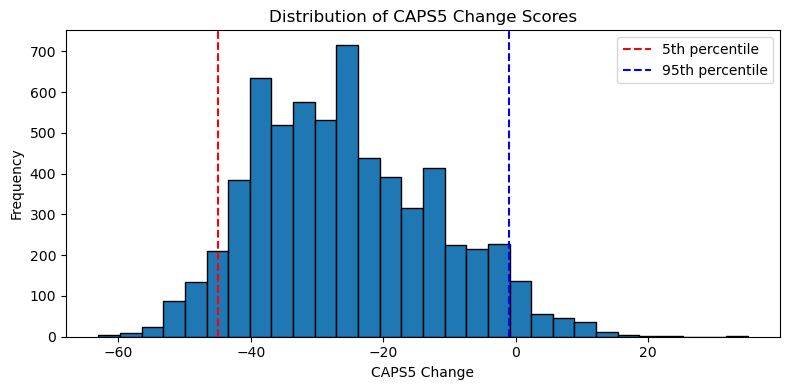

In [71]:
# Plot to check for ceiling/floor effects in CAPS5 change
plt.figure(figsize=(8, 4))
plt.hist(df['caps5_change_baseline'], bins=30, edgecolor='black')
plt.axvline(df['caps5_change_baseline'].quantile(0.05), color='red', linestyle='--', label='5th percentile')
plt.axvline(df['caps5_change_baseline'].quantile(0.95), color='blue', linestyle='--', label='95th percentile')
plt.title("Distribution of CAPS5 Change Scores")
plt.xlabel("CAPS5 Change")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


# Save the plot
output_dir = "outputs/secondary_analysis"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "Distribution of CAPS5 Change Scores.png"))
plt.close()

In [67]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Load main dataset
df = pd.read_csv("final_prepared_data.csv")
df["CAT_SEDATIVES"] = ((df["CAT_Benzodiazepine"] == 1) | (df["CAT_Z_drugs"] == 1)).astype(int)

# Define treatment groups and covariates
medication_groups = [
    'CAT_Antidepressiva',
    'CAT_Antipsychotica',
    'CAT_SEDATIVES'
]

covariates_map = {
    "CAT_Antidepressiva": covariates_cat_antidepressiva,
    "CAT_Antipsychotica": covariates_cat_antipsychotica,
    "CAT_SEDATIVES": covariates_cat_benzodiazepine
}

for group in medication_groups:
    print(f"\n🚀 Estimating Propensity Score for: {group}")

    try:
        # Treatment variable
        T = df[group]

        # Covariates for this group
        X = df[covariates_map[group]]

        # Fit XGBoost classifier
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X, T)

        # Predict propensity scores
        ps_scores = model.predict_proba(X)[:, 1]

        # Save to file
        output_folder = os.path.join("outputs", "secondary_analysis", group)
        os.makedirs(output_folder, exist_ok=True)

        ps_df = pd.DataFrame({
            f"ps_{group}_composite": ps_scores
        })
        output_path = os.path.join(output_folder, f"propensity_scores_{group}_composite.xlsx")
        ps_df.to_excel(output_path, index=False)

        print(f"✅ Saved PS to: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {group}: {e}")



🚀 Estimating Propensity Score for: CAT_Antidepressiva
✅ Saved PS to: outputs\secondary_analysis\CAT_Antidepressiva\propensity_scores_CAT_Antidepressiva_composite.xlsx

🚀 Estimating Propensity Score for: CAT_Antipsychotica
✅ Saved PS to: outputs\secondary_analysis\CAT_Antipsychotica\propensity_scores_CAT_Antipsychotica_composite.xlsx

🚀 Estimating Propensity Score for: CAT_SEDATIVES
✅ Saved PS to: outputs\secondary_analysis\CAT_SEDATIVES\propensity_scores_CAT_SEDATIVES_composite.xlsx


In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Functions to calculate balance
# -------------------------------
def calculate_smd(x1, x2, w1=None, w2=None):
    def weighted_mean(x, w=None):
        return np.average(x, weights=w) if w is not None else np.mean(x)
    def weighted_var(x, w=None):
        if w is not None:
            mean = np.average(x, weights=w)
            return np.average((x - mean) ** 2, weights=w)
        return np.var(x, ddof=1)
    m1, v1 = weighted_mean(x1, w1), weighted_var(x1, w1)
    m2, v2 = weighted_mean(x2, w2), weighted_var(x2, w2)
    pooled_sd = np.sqrt((v1 + v2) / 2)
    return np.abs(m1 - m2) / pooled_sd if pooled_sd > 0 else 0

def variance_ratio(x1, x2, w1=None, w2=None):
    def weighted_var(x, w=None):
        if w is not None:
            mean = np.average(x, weights=w)
            return np.average((x - mean) ** 2, weights=w)
        return np.var(x, ddof=1)
    v1 = weighted_var(x1, w1)
    v2 = weighted_var(x2, w2)
    return max(v1 / v2, v2 / v1) if v1 > 0 and v2 > 0 else 1

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("final_prepared_data.csv")
df["CAT_SEDATIVES"] = ((df["CAT_Benzodiazepine"] == 1) | (df["CAT_Z_drugs"] == 1)).astype(int)

# -------------------------------
# Use only these 3 groups
# -------------------------------
medication_groups = [
    'CAT_Antidepressiva',
    'CAT_Antipsychotica',
    'CAT_SEDATIVES'
]

# -------------------------------
# Use simplified covariates map
# -------------------------------
covariates_map = {
    "CAT_Antidepressiva": covariates_cat_antidepressiva,
    "CAT_Antipsychotica": covariates_cat_antipsychotica,
    "CAT_SEDATIVES": covariates_cat_benzodiazepine  # Benzodiazepines + Z-drugs
}

# -------------------------------
# Main Loop
# -------------------------------
for group in medication_groups:
    print(f"\n🔍 Processing {group}...")

    try:
        output_folder = os.path.join("outputs", "secondary_analysis", group)

        ps_path = os.path.join(output_folder, f"propensity_scores_{group}_composite.xlsx")

        if not os.path.exists(ps_path):
            print(f"⚠️ Missing propensity score file for {group}. Skipping.")
            continue

        ps_df = pd.read_excel(ps_path)
        ps_col = f"ps_{group}_composite"
        if ps_col not in ps_df.columns:
            print(f"❌ Composite PS column not found in {ps_path}")
            continue

        df["propensity_score"] = ps_df[ps_col]
        T = df[group]
        W = df["propensity_score"]

        # IPTW Weights
        p_treat = T.mean()
        p_control = 1 - p_treat
        weights = (p_treat / W) * T + (p_control / (1 - W)) * (1 - T)
        weights = weights.clip(lower=0.01, upper=10)

        covariates = covariates_map[group] + ['propensity_score']
        smd_unw, smd_w, vr_unw, vr_w, severity = [], [], [], [], []

        for cov in covariates:
            x1, x0 = df.loc[T == 1, cov], df.loc[T == 0, cov]
            w1, w0 = weights[T == 1], weights[T == 0]
            su = calculate_smd(x1, x0)
            sw = calculate_smd(x1, x0, w1, w0)
            vu = variance_ratio(x1, x0)
            vw = variance_ratio(x1, x0, w1, w0)

            smd_unw.append(su)
            smd_w.append(sw)
            vr_unw.append(vu)
            vr_w.append(vw)

            if sw <= 0.1:
                severity.append("Good")
            elif sw <= 0.2:
                severity.append("Moderate")
            else:
                severity.append("Poor")

        labels = [c if c != "propensity_score" else "Propensity Score" for c in covariates]

        numeric_df = pd.DataFrame({
            "Covariate": labels,
            "SMD_Unweighted": smd_unw,
            "SMD_Weighted": smd_w,
            "Imbalance_Severity": severity,
            "VR_Unweighted": vr_unw,
            "VR_Weighted": vr_w
        })
        numeric_path = os.path.join(output_folder, f"covariate_balance_table_{group}.xlsx")
        numeric_df.to_excel(numeric_path, index=False)
        print(f"📊 Exported numeric summary to: {numeric_path}")

        # Love Plot
        fig, axes = plt.subplots(1, 2, figsize=(18, len(labels) * 0.45))
        y_pos = np.arange(len(labels))

        axes[0].scatter(smd_unw, y_pos, color='red', label="Unweighted")
        axes[0].scatter(smd_w, y_pos, color='blue', label="Weighted")

        # Highlight SMD severity
        added_labels = set()
        for i, sw in enumerate(smd_w):
            if severity[i] == "Moderate":
                label = "Moderate" if "Moderate" not in added_labels else None
                axes[0].scatter(sw, y_pos[i], color='orange', s=100, label=label)
                added_labels.add("Moderate")
            elif severity[i] == "Poor":
                label = "Poor" if "Poor" not in added_labels else None
                axes[0].scatter(sw, y_pos[i], color='gold', edgecolors='black', s=100, label=label)
                added_labels.add("Poor")

        axes[0].axvline(0.1, color='gray', linestyle='--', label="Threshold 0.1")
        axes[0].axvline(0.2, color='black', linestyle='--', label="Threshold 0.2")
        axes[0].set_xlim(0, max(max(smd_unw), max(smd_w), 0.25) + 0.05)
        axes[0].set_yticks(y_pos)
        axes[0].set_yticklabels(labels)
        axes[0].invert_yaxis()
        axes[0].set_title("Standardized Mean Differences (SMD)")

        # Add severity legend
        axes[0].scatter([], [], color='gold', edgecolors='black', s=100, label="Poor (SMD > 0.2)")
        axes[0].scatter([], [], color='orange', s=100, label="Moderate (0.1 < SMD ≤ 0.2)")
        axes[0].scatter([], [], color='green', s=100, label="Good (SMD ≤ 0.1)")
        axes[0].legend(loc="upper right")
        axes[0].grid(True)

        axes[1].scatter(vr_unw, y_pos, color='red', label="Unweighted", marker='o')
        axes[1].scatter(vr_w, y_pos, color='blue', label="Weighted", marker='x')
        axes[1].set_title("Variance Ratio (VR)")
        axes[1].axvline(2, color='gray', linestyle='--')
        axes[1].axvline(0.5, color='gray', linestyle='--')
        axes[1].set_xlim(0, max(max(vr_unw), max(vr_w), 2.5) + 0.5)
        axes[1].set_yticks(y_pos)
        axes[1].set_yticklabels([])
        axes[1].invert_yaxis()
        axes[1].legend()
        axes[1].grid(True)

        fig.suptitle(f"Covariate Balance for {group.replace('CAT_', '')}", fontsize=14, weight='bold')
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plot_path = os.path.join(output_folder, f"love_plot_{group}.png")
        fig.savefig(plot_path, dpi=300)
        plt.close()
        print(f"✅ Saved love plot: {plot_path}")

        print(f"📏 Max weighted SMD for {group}: {np.max(smd_w):.3f}")

    except Exception as e:
        print(f"❌ Error in {group}: {e}")



🔍 Processing CAT_Antidepressiva...
📊 Exported numeric summary to: outputs\secondary_analysis\CAT_Antidepressiva\covariate_balance_table_CAT_Antidepressiva.xlsx
✅ Saved love plot: outputs\secondary_analysis\CAT_Antidepressiva\love_plot_CAT_Antidepressiva.png
📏 Max weighted SMD for CAT_Antidepressiva: 12.034

🔍 Processing CAT_Antipsychotica...
📊 Exported numeric summary to: outputs\secondary_analysis\CAT_Antipsychotica\covariate_balance_table_CAT_Antipsychotica.xlsx
✅ Saved love plot: outputs\secondary_analysis\CAT_Antipsychotica\love_plot_CAT_Antipsychotica.png
📏 Max weighted SMD for CAT_Antipsychotica: 1.232

🔍 Processing CAT_SEDATIVES...
📊 Exported numeric summary to: outputs\secondary_analysis\CAT_SEDATIVES\covariate_balance_table_CAT_SEDATIVES.xlsx
✅ Saved love plot: outputs\secondary_analysis\CAT_SEDATIVES\love_plot_CAT_SEDATIVES.png
📏 Max weighted SMD for CAT_SEDATIVES: 1.090
